# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
!pip install PyDrive
!pip install keras==2.2.4
!pip install tensorflow==1.13.1
!pip install git+https://github.com/darecophoenixx/wordroid.sblo.jp

  Cloning https://github.com/darecophoenixx/wordroid.sblo.jp to /tmp/pip-req-build-wlbqohqo
  Running command git clone -q https://github.com/darecophoenixx/wordroid.sblo.jp /tmp/pip-req-build-wlbqohqo
  Created wheel for wordroid.sblo.jp: filename=wordroid.sblo.jp-0.0.1-cp36-none-any.whl size=33710 sha256=4f4f50edae43a09569c3cfbf300a37c67a9319f1c9c0b7bb0446f00bef8991f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-sl1j49z1/wheels/3d/6d/24/44e7d6dc47b39e74772a04beb27433ba2ebed90876394cda60
Successfully built wordroid.sblo.jp


In [2]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(0)
np.random.seed(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,self.imsize)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (0.5)*ssim(individual.reshape(self.imsize),self.img.reshape(self.imsize)) 

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"16oao6c9BTb33sbaFzCDJ1sGQn4Z0ILS7"}) 
downloaded.GetContentFile('rbfnn_v2.h5')   

num_lm0 = 100
num_lm = num_lm0 * 10
init_wgt = np.zeros(((1000, 784)))

inp = Input(shape=(28*28,), name='inp')
oup = GaussianKernel(num_lm, 28*28,
                     kernel_gamma='auto', weights=[init_wgt],
                     name='gkernel1')(inp)
oup = Dense(10, activation='softmax')(oup)
model = Model(inp, oup)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("rbfnn_v2.h5")

Instructions for updating:
Colocations handled automatically by placer.


# Prepare Data

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
def prepare_data(X,y):
  X = X.reshape((X.shape[0], -1))
  X_sc = X / 255.0
  y_cat = to_categorical(y)
  return X_sc, y_cat

In [9]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_sc = X_train / 255.0
X_sc.shape
y_cat = to_categorical(y_train)
X_test = X_test.reshape((X_test.shape[0], -1))
X_test_sc = X_test / 255.0
y_pred_test = model.predict(X_test_sc)
y_pred_train = model.predict(X_sc)
print("Training accuracy: ",accuracy_score(y_train,np.argmax(y_pred_train,axis=1)))
print("Test accuracy: ",accuracy_score(y_test,np.argmax(y_pred_test,axis=1)))

Training accuracy:  0.93305
Test accuracy:  0.9297


In [0]:
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
  original = []
  adversarial = []
  original_y = []
  adversarial_y = []
  for sample_class in range(num_classes):
    labels = y_test[(y_test==sample_class).reshape(num_samples)]
    samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
    samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
    samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
    for cluster in range(num_clusters):
      subsamples = np.where(kmeans==cluster)[0]
      ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
      original.extend(samples_orig[ori])
      original_y.extend(labels[ori])
      adversarial.extend(samples_orig[adv])
      adversarial_y.extend(labels[adv])
  return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

In [0]:
discard,subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_test_sc,y_test,28,1,5,10,10000)

In [12]:
subsample.shape

(1021, 784)

In [13]:
subsample_y.shape

(1021,)

In [0]:
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(subsample_sc)

In [15]:
print("Accuracy on subsample: ", accuracy_score(subsample_y,np.argmax(y_pred_subsample,axis=1)))

Accuracy on subsample:  0.9333986287952988


In [0]:
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,28,1,5,10,1021)

In [17]:
original.shape

(895, 784)

In [18]:
adversarial.shape

(126, 784)

In [19]:
adversarial_y.shape

(126,)

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 20, #50 (5) #200 (1)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2) (it was 2000)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4) (it was 125)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


25  :  0.5177102617079169 25
50  :  0.6159335290675351 25
75  :  0.6069851857604673 25
100  :  0.6106484965323584 25
125  :  0.6182050669112984 25
150  :  0.6115058667993727 25
175  :  0.6128342011868556 25
200  :  0.6444554822148278 25
225  :  0.6444554822148278 25
250  :  0.6444554822148278 25
275  :  0.6444554822148278 25
300  :  0.6444554822148278 25
325  :  0.6452497951725378 25
350  :  0.6470124035960617 25
375  :  0.651470847418007 25
400  :  0.651470847418007 25
425  :  0.6529216192500659 25
450  :  0.6539166014426279 25
475  :  0.6563203946646176 25
500  :  0.6563203946646176 25
525  :  0.6586099662587637 25
550  :  0.6591679950921503 25
575  :  0.6603624765298076 25
600  :  0.6608397166952715 25
625  :  0.6614287275135228 25
650  :  0.6622274532014583 25
675  :  0.6639692089833208 25
700  :  0.6646716204176897 25
725  :  0.6646686358901732 25
750  :  0.6650786788896389 25
775  :  0.6656557544572645 25
800  :  0.6659847685665821 25
825  :  0.6659793241328964 25
850  :  0.66603

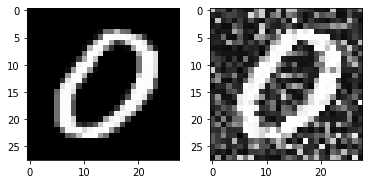

25  :  0.4874228867191417 25
50  :  0.6081155524495305 25
75  :  0.5984234298089277 25
100  :  0.5876295514069373 25
125  :  0.5919081454478645 25
150  :  0.5917035202660709 25
175  :  0.598601168792343 25
200  :  0.6082827445227225 25
225  :  0.6097560730195611 25
250  :  0.6109223570990819 25
275  :  0.6215510331139158 25
300  :  0.6204783013618705 25
325  :  0.6220493680625898 25
350  :  0.6284996913161963 25
375  :  0.6281670014175671 25
400  :  0.629171382741207 25
425  :  0.6307312442128601 25
450  :  0.6308356960653521 25
475  :  0.6308356960653521 25
500  :  0.6309462069451428 25
525  :  0.6332528258006406 25
550  :  0.6330970907173465 25
575  :  0.6332352091642477 25
600  :  0.633963686431025 25
625  :  0.6338302801784159 25
650  :  0.6338333838196129 25
675  :  0.6347631767728399 25
700  :  0.6347222464530875 25
725  :  0.6359570081885302 25
750  :  0.6361502264470065 25
775  :  0.6367695845733072 25
800  :  0.6366075314904034 25
825  :  0.6366075314904034 25
850  :  0.636960

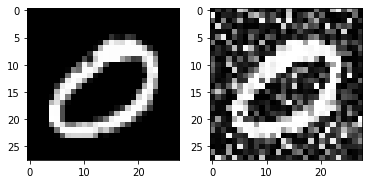

25  :  0.3051999028456994 25
50  :  0.5957517900988801 25
75  :  0.5409908515947026 25
100  :  0.5559743971503679 25
125  :  0.5543930934856209 25
150  :  0.5801338196640046 25
175  :  0.587489210578135 25
200  :  0.5960136877445501 25
225  :  0.6013912116012775 25
250  :  0.6108574854140769 25
275  :  0.6106864853286066 25
300  :  0.6106864853286066 25
325  :  0.6107718718402009 25
350  :  0.6107718718402009 25
375  :  0.6107718718402009 25
400  :  0.6121370085451853 25
425  :  0.6153553166543883 25
450  :  0.6153548288837225 25
475  :  0.6197743987839535 25
500  :  0.6195751096439142 25
525  :  0.6202558941240892 25
550  :  0.6218786014524597 25
575  :  0.6243526692655363 25
600  :  0.6243526692655363 25
625  :  0.6243526692655363 25
650  :  0.6261031831606346 25
675  :  0.6267491194958281 25
700  :  0.6268699063841592 25
725  :  0.6267592038855521 25
750  :  0.6267592038855521 25
775  :  0.6272183872166295 25
800  :  0.6272183872166295 25
825  :  0.6273614636514081 25
850  :  0.6273

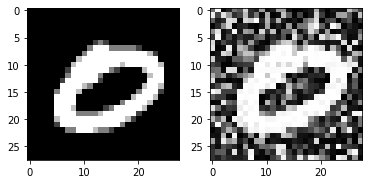

25  :  0.12404863461243909 25
50  :  0.5110859987939689 25
75  :  0.39274377665589755 25
100  :  0.46563944306859784 25
125  :  0.5769298194726147 25
150  :  0.5781309722423238 25
175  :  0.5904764968266838 25
200  :  0.6070083352894089 25
225  :  0.6202881463997574 25
250  :  0.615349672245534 25
275  :  0.620937153535326 25
300  :  0.6210961475226062 25
325  :  0.6223106447241968 25
350  :  0.6250017984186584 25
375  :  0.6250017984186584 25
400  :  0.6250017984186584 25
425  :  0.6295191206613155 25
450  :  0.6300008940112417 25
475  :  0.6317146515418846 25
500  :  0.6305953577984436 25
525  :  0.6305953577984436 25
550  :  0.6308217769453736 25
575  :  0.6330116589972435 25
600  :  0.6330124328307454 25
625  :  0.6349903994221409 25
650  :  0.6355976545730941 25
675  :  0.6359338705961883 25
700  :  0.6388071217652433 25
725  :  0.6395707422377442 25
750  :  0.6409207522292586 25
775  :  0.6408239195323406 25
800  :  0.6423707169524356 25
825  :  0.6423728500636652 25
850  :  0.64

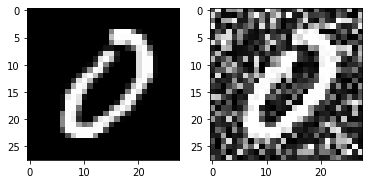

25  :  0.6266498648502881 25
50  :  0.6433945821862812 25
75  :  0.6322410384539183 25
100  :  0.6298849652883095 25
125  :  0.6361442984479694 25
150  :  0.6386522700443042 25
175  :  0.6487910827054844 25
200  :  0.6543479938716081 25
225  :  0.6542383486487853 25
250  :  0.6570002140907496 25
275  :  0.6570002140907496 25
300  :  0.6573431198885367 25
325  :  0.659882782167095 25
350  :  0.6607896401266204 25
375  :  0.6623871154244678 25
400  :  0.6627300293873462 25
425  :  0.6635694284996458 25
450  :  0.6638048383527126 25
475  :  0.6637729095429583 25
500  :  0.6653922400574082 25
525  :  0.6657726055690641 25
550  :  0.6670730603985708 25
575  :  0.6671642256167281 25
600  :  0.6672606386358113 25
625  :  0.6680436304900237 25
650  :  0.6686374506396594 25
675  :  0.668716417076437 25
700  :  0.668963662324012 25
725  :  0.6695123570006847 25
750  :  0.6694529581011314 25
775  :  0.6696798865554647 25
800  :  0.6703160880393868 25
825  :  0.6702617004029972 25
850  :  0.670784

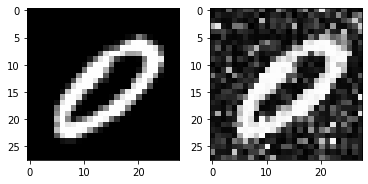

25  :  0.5418272967022807 25
50  :  0.6174283310599877 25
75  :  0.622791786689641 25
100  :  0.6175099170539134 25
125  :  0.6125107854335251 25
150  :  0.6202374832090762 25
175  :  0.6174557161817931 25
200  :  0.6207614448524857 25
225  :  0.6218340244962949 25
250  :  0.6305675803294881 25
275  :  0.6325360220345648 25
300  :  0.6326388127527866 25
325  :  0.6326388127527866 25
350  :  0.6349569383809297 25
375  :  0.636235371457765 25
400  :  0.6364375976569288 25
425  :  0.6374940703832651 25
450  :  0.63709310193102 25
475  :  0.63709310193102 25
500  :  0.63709310193102 25
525  :  0.6378870595561218 25
550  :  0.6382259421202692 25
575  :  0.6402153977221388 25
600  :  0.6409942946398124 25
625  :  0.6412558731045938 25
650  :  0.6412558731045938 25
675  :  0.6420047227376912 25
700  :  0.6420572160992772 25
725  :  0.6423024660408326 25
750  :  0.6427251700757446 25
775  :  0.6436144824253274 25
800  :  0.6451759276791392 25
825  :  0.6451717255516844 25
Time:  74.51245784759

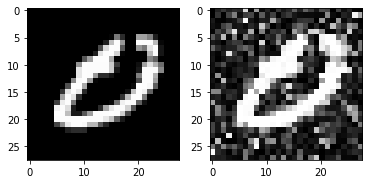

25  :  0.19638564089284555 25
50  :  0.5015370965729153 25
75  :  0.3914767749335369 25
100  :  0.10222688869108851 25
125  :  0.37627668176214923 25
150  :  -0.31376748384735687 25
175  :  -0.31376748384735687 25
200  :  -0.31376748384735687 25
225  :  -0.31376748384735687 25
250  :  -0.31376748384735687 25
275  :  -0.31376748384735687 25
300  :  -0.31376748384735687 25
325  :  -0.31376748384735687 25
350  :  -0.31376748384735687 25
375  :  -0.31376748384735687 25
400  :  -0.31376748384735687 25
425  :  -0.31376748384735687 25
450  :  -0.31376748384735687 25
475  :  -0.31376748384735687 25
500  :  -0.31376748384735687 25
525  :  -0.31376748384735687 25
550  :  -0.31376748384735687 25
575  :  -0.31376748384735687 25
600  :  -0.31376748384735687 25
625  :  -0.31376748384735687 25
650  :  -0.31347786144072437 25
675  :  -0.31350815341487626 25
700  :  -0.31350815341487626 25
725  :  -0.31350815341487626 25
750  :  -0.31350815341487626 25
775  :  -0.31350815341487626 25
800  :  -0.3135081

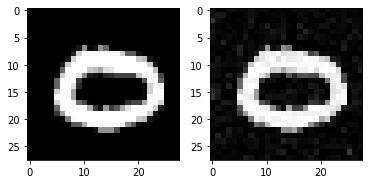

25  :  -0.1733247419245649 25
50  :  0.4993788189746672 25
75  :  -0.01801992326999871 25
100  :  0.07434313887657346 25
125  :  -0.2544550973538291 25
150  :  -0.2878407399013085 25
175  :  -0.2878407399013085 25
200  :  -0.2878407399013085 25
225  :  -0.2878407399013085 25
250  :  -0.2878407399013085 25
275  :  -0.2878407399013085 25
300  :  -0.2878407399013085 25
325  :  -0.2878407399013085 25
350  :  -0.2878407399013085 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


375  :  -0.2878407399013085 25
400  :  -0.2878407399013085 25
425  :  -0.2878407399013085 25
450  :  -0.2878407399013085 25
475  :  -0.2878407399013085 25
500  :  -0.2878407399013085 25
525  :  -0.2878407399013085 25
550  :  -0.2878407399013085 25
575  :  -0.2878407399013085 25
600  :  -0.2878407399013085 25
625  :  -0.2878407399013085 25
650  :  -0.2878407399013085 25
675  :  -0.2878407399013085 25
700  :  -0.2878407399013085 25
725  :  -0.2878407399013085 25
750  :  -0.2878407399013085 25
775  :  -0.2878407399013085 25
800  :  -0.2878407399013085 25
825  :  -0.2878407399013085 25
850  :  -0.2878407399013085 25
875  :  -0.2878407399013085 25
900  :  -0.2878407399013085 25
925  :  -0.2878407399013085 25
Time:  80.81229972839355  seconds
Predicted class:  [0]


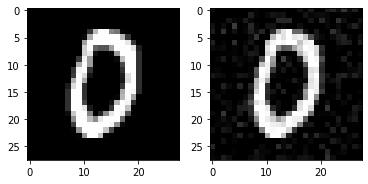

25  :  0.34626805174004194 25
50  :  0.5650100521714575 25
75  :  0.4898631844384914 25
100  :  0.550448949723746 25
125  :  0.5673192111901159 25
150  :  0.5799283892561992 25
175  :  0.5869398097542464 25
200  :  0.5907265177563479 25
225  :  0.600578866015061 25
250  :  0.5987290018614362 25
275  :  0.6069167892795919 25
300  :  0.608927533734679 25
325  :  0.6117663331042918 25
350  :  0.6145066946170182 25
375  :  0.6149644438286733 25
400  :  0.6145066946170182 25
425  :  0.614780275110108 25
450  :  0.6166954468875196 25
475  :  0.6169976723238926 25
500  :  0.6178358583505369 25
525  :  0.6207639748806733 25
550  :  0.6209836147555269 25
575  :  0.6222577069287948 25
600  :  0.6218136952689474 25
625  :  0.6222004771146897 25
650  :  0.6222708021048396 25
675  :  0.6236218484432066 25
700  :  0.6236059237964131 25
725  :  0.6237099288923218 25
750  :  0.6238443098665316 25
775  :  0.6241236231035177 25
800  :  0.6242019920320726 25
825  :  0.6244347577798673 25
850  :  0.624640

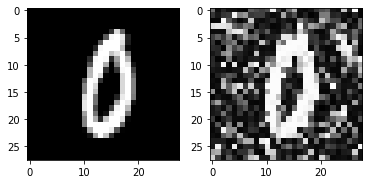

25  :  0.07482981474298994 25
50  :  0.5811255765175408 25
75  :  0.3399624706057831 25
100  :  0.3985640956197016 25
125  :  -0.19697739547226786 25
150  :  -0.15721553420037082 25
175  :  -0.21282256468420893 25
200  :  -0.2099181989057774 25
225  :  0.3404400513694558 25
250  :  0.38071240431351583 25
275  :  0.4930044023028583 25
300  :  0.5152617855398185 25
325  :  0.6091368057359694 25
350  :  0.6195016008133667 25
375  :  0.6138194656798424 25
400  :  0.6138194656798424 25
425  :  0.6209236153329083 25
450  :  0.6201867184386444 25
475  :  0.6223874437760648 25
500  :  0.6248774196998049 25
525  :  0.6261999924657301 25
550  :  0.6271276785929946 25
575  :  0.6276585463695243 25
600  :  0.6294168673797231 25
625  :  0.6299867107146044 25
650  :  0.6299837793019295 25
675  :  0.6299837793019295 25
700  :  0.6317911367087337 25
725  :  0.6332218424520595 25
750  :  0.63458010586391 25
775  :  0.63458010586391 25
800  :  0.635564967160914 25
825  :  0.6365039722805372 25
850  :  0

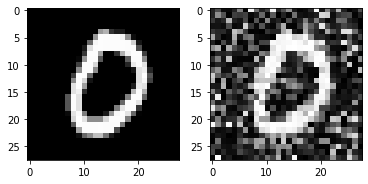

25  :  0.693888233108131 25
50  :  0.6991841693224239 25
75  :  0.695602042895155 25
100  :  0.6996915838164608 25
125  :  0.6875252728117375 25
150  :  0.6905732363695558 25
175  :  0.6928212093299445 25
200  :  0.6921425400523182 25
225  :  0.6948665471081786 25
250  :  0.6973913422864533 25
275  :  0.6977655569269995 25
300  :  0.7006811148712151 25
325  :  0.7009676421885318 25
350  :  0.702320746013686 25
375  :  0.7039290855263431 25
400  :  0.7045798425400918 25
425  :  0.7047879266282274 25
450  :  0.7058682727727181 25
475  :  0.706982387379005 25
500  :  0.707348916037911 25
525  :  0.7078053375609707 25
550  :  0.7088690695246658 25
575  :  0.7101348901851132 25
600  :  0.7106387305738592 25
625  :  0.7105985429869963 25
650  :  0.7114580528327646 25
675  :  0.7115984083233078 25
700  :  0.7130271062411352 25
725  :  0.7130271062411352 25
750  :  0.7131595925169387 25
775  :  0.7137164737427177 25
800  :  0.7138796214257501 25
825  :  0.7140274785754368 25
850  :  0.71412456

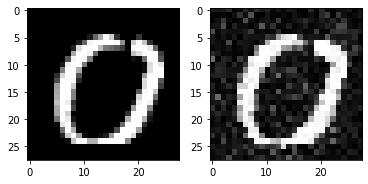

25  :  0.17043089077639426 25
50  :  0.5788609379556636 25
75  :  0.36060096979415773 25
100  :  0.42504373873474355 25
125  :  0.5226474409397412 25
150  :  0.5149534707844061 25
175  :  0.5547942803346597 25
200  :  0.5820698133621405 25
225  :  0.5981525305746692 25
250  :  0.6124810402060015 25
275  :  0.6124810402060015 25
300  :  0.6140376938933604 25
325  :  0.6175717838918361 25
350  :  0.6193980218130523 25
375  :  0.6257613158766291 25
400  :  0.6263142902321501 25
425  :  0.6279416527689266 25
450  :  0.6317352134032852 25
475  :  0.6317161851211139 25
500  :  0.6316896186698664 25
525  :  0.6316896186698664 25
550  :  0.6331022366034496 25
575  :  0.634191151168251 25
600  :  0.6351478597994279 25
625  :  0.6356595515395047 25
650  :  0.6358081449925613 25
675  :  0.636560023024224 25
700  :  0.6375559872840928 25
725  :  0.6377486817198584 25
750  :  0.6381127574788211 25
775  :  0.6382305331768345 25
800  :  0.6383431894623521 25
825  :  0.6391460019554314 25
850  :  0.63

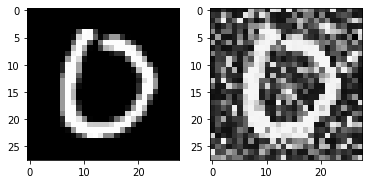

25  :  0.6840005290820348 25
50  :  0.6865275859078471 25
75  :  0.686007274344091 25
100  :  0.6924833910283983 25
125  :  0.690243223898881 25
150  :  0.6950926286478538 25
175  :  0.6953019537284664 25
200  :  0.6953683585349812 25
225  :  0.6953683585349812 25
250  :  0.6953683585349812 25
275  :  0.6953683585349812 25
300  :  0.6953683585349812 25
325  :  0.6971811481144334 25
350  :  0.6990551896297956 25
375  :  0.7014328910362 25
400  :  0.7027371886429399 25
425  :  0.7030882559263534 25
450  :  0.7038242636786194 25
475  :  0.703697938131415 25
500  :  0.7049649414728016 25
525  :  0.7049649414728016 25
550  :  0.7052098389062764 25
575  :  0.7052425474137833 25
600  :  0.7056400423328201 25
625  :  0.7056414727229874 25
650  :  0.7061915792913057 25
675  :  0.7061908874530867 25
700  :  0.7061908874530867 25
725  :  0.7068700057394235 25
750  :  0.7068837986708646 25
775  :  0.707002007822668 25
800  :  0.7076435146605854 25
Time:  70.8480236530304  seconds
Predicted class: 

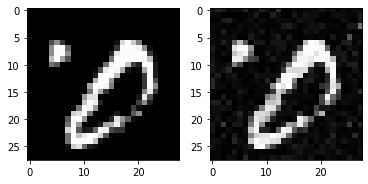

25  :  -0.29502693056507867 25
50  :  -0.26312306220261267 25
75  :  -0.10346345380036494 25
100  :  0.11641982646205716 25
125  :  0.4438404868597462 25
150  :  0.5003640577096022 25
175  :  0.5098570676222705 25
200  :  0.5434202823993313 25
225  :  0.5502469746597825 25
250  :  0.5506171204873999 25
275  :  0.5509279453396433 25
300  :  0.5546528295753645 25
325  :  0.5595426309762849 25
350  :  0.5625738684323878 25
375  :  0.568912812327428 25
400  :  0.569467161509169 25
425  :  0.5742139573564892 25
450  :  0.57432118488256 25
475  :  0.5746397954048674 25
500  :  0.5797725428134988 25
525  :  0.580041609643038 25
550  :  0.5809839693004581 25
575  :  0.581980582560425 25
600  :  0.5836535774462496 25
625  :  0.5842037052526903 25
650  :  0.5853863728057175 25
675  :  0.5856177623256975 25
700  :  0.586487823435722 25
725  :  0.5875423339710534 25
750  :  0.58776239771108 25
775  :  0.5877532680338109 25
800  :  0.5881175330828821 25
825  :  0.5881026529287803 25
850  :  0.58808

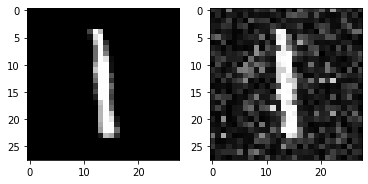

25  :  -0.3637882236037367 25
50  :  -0.165918770837839 25
75  :  -0.08835668737438994 25
100  :  0.18664894140114457 25
125  :  0.43594572802293113 25
150  :  0.4882427447096287 25
175  :  0.5211999997540961 25
200  :  0.5349078206065998 25
225  :  0.549525732780825 25
250  :  0.5600646629338148 25
275  :  0.5634452492908321 25
300  :  0.5745614814221255 25
325  :  0.574073731388268 25
350  :  0.5761233493388768 25
375  :  0.5761233493388768 25
400  :  0.5761233493388768 25
425  :  0.578546252712657 25
450  :  0.5788520540831535 25
475  :  0.578983378359638 25
500  :  0.5801041837047964 25
525  :  0.5809749427525316 25
550  :  0.5807596304940184 25
575  :  0.5807596304940184 25
600  :  0.5810790487178413 25
625  :  0.5818104060254145 25
650  :  0.5827370256811586 25
675  :  0.5826878933068506 25
700  :  0.5832459884169678 25
725  :  0.5840580015778458 25
750  :  0.58386284431563 25
775  :  0.5842541075872217 25
800  :  0.5856422008699997 25
825  :  0.5859500299101182 25
850  :  0.5863

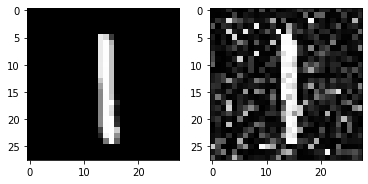

25  :  -0.04687516356583127 25
50  :  0.3626242994400162 25
75  :  0.35381993677512996 25
100  :  0.3971521887707682 25
125  :  0.5146968081253558 25
150  :  0.5501121473762763 25
175  :  0.5496842275739071 25
200  :  0.5552722679207887 25
225  :  0.5555845148108647 25
250  :  0.5598651266205877 25
275  :  0.5598651266205877 25
300  :  0.5604588385027939 25
325  :  0.5611202016184248 25
350  :  0.5614115134720109 25
375  :  0.562483098467804 25
400  :  0.5653964770045015 25
425  :  0.5671545069865093 25
450  :  0.5675163603440655 25
475  :  0.5673983473560508 25
500  :  0.5693174125189935 25
525  :  0.5692719436488171 25
550  :  0.5692719436488171 25
575  :  0.5692719436488171 25
600  :  0.5706911898879996 25
625  :  0.5706813555980429 25
650  :  0.5712600240110908 25
675  :  0.5715986532689409 25
700  :  0.5715986532689409 25
725  :  0.5717360160158311 25
750  :  0.5718697845735684 25
775  :  0.5718620746025056 25
800  :  0.5724083850680002 25
825  :  0.5728648064874797 25
850  :  0.5

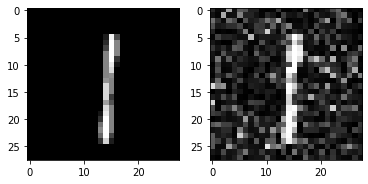

25  :  -0.37148103314250724 25
50  :  -0.37148103314250724 25
75  :  -0.37148103314250724 25
100  :  -0.37148103314250724 25
125  :  -0.37148103314250724 25
150  :  -0.37148103314250724 25
175  :  -0.37148103314250724 25
200  :  -0.37148103314250724 25
225  :  -0.37148103314250724 25
250  :  -0.37148103314250724 25
275  :  -0.37148103314250724 25
300  :  -0.37148103314250724 25
325  :  -0.37148103314250724 25
350  :  -0.37148103314250724 25
375  :  -0.37148103314250724 25
400  :  -0.37148103314250724 25
425  :  -0.37148103314250724 25
450  :  -0.37148103314250724 25
475  :  -0.37148103314250724 25
500  :  -0.37148103314250724 25
525  :  -0.37148103314250724 25
550  :  -0.37148103314250724 25
575  :  -0.37148103314250724 25
600  :  -0.37148103314250724 25
625  :  -0.37148103314250724 25
650  :  -0.37148103314250724 25
675  :  -0.37148103314250724 25
700  :  -0.37148103314250724 25
725  :  -0.37148103314250724 25
750  :  -0.37148103314250724 25
775  :  -0.37148103314250724 25
800  :  -0.

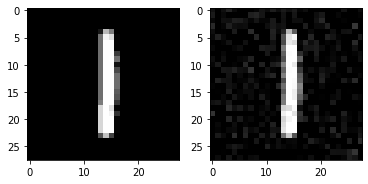

25  :  -0.1863986408396858 25
50  :  0.10224074321075166 25
75  :  -0.051454093405700146 25
100  :  0.3704160533056895 25
125  :  0.37423212637974523 25
150  :  0.5050651491185253 25
175  :  0.5412037054577663 25
200  :  0.551077177053723 25
225  :  0.5625595082257824 25
250  :  0.5782733925945507 25
275  :  0.5935890775100038 25
300  :  0.5942169612767201 25
325  :  0.5974220879928405 25
350  :  0.5977769764421212 25
375  :  0.5977769764421212 25
400  :  0.599847642770096 25
425  :  0.5999461904503401 25
450  :  0.601486526150195 25
475  :  0.6032173442736869 25
500  :  0.6032173442736869 25
525  :  0.6032181663437367 25
550  :  0.6044017618179837 25
575  :  0.6050373671668466 25
600  :  0.6057626321452285 25
625  :  0.6062860776322196 25
650  :  0.6063297812334371 25
675  :  0.6064047387154589 25
700  :  0.6065842105107733 25
725  :  0.6070679934080053 25
750  :  0.607061370701612 25
775  :  0.6071205039848502 25
800  :  0.6075170027817707 25
825  :  0.6075170027817707 25
850  :  0.6

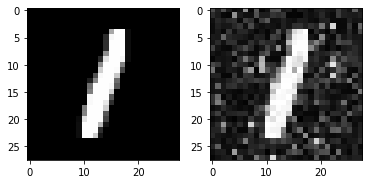

25  :  -0.1211004096159167 25
50  :  0.1798449115140362 25
75  :  0.21145296155593676 25
100  :  0.4640025424352032 25
125  :  0.45264431284140577 25
150  :  0.5082390427009069 25
175  :  0.518874230450328 25
200  :  0.521036148284112 25
225  :  0.5195908688035011 25
250  :  0.5360839017859654 25
275  :  0.5359591694699268 25
300  :  0.5359591694699268 25
325  :  0.5542841683946262 25
350  :  0.5560246830991313 25
375  :  0.5576781237624189 25
400  :  0.5647366215980855 25
425  :  0.5699367092850934 25
450  :  0.5741780678569263 25
475  :  0.5764066867721017 25
500  :  0.5807019192405675 25
525  :  0.5837873587551524 25
550  :  0.5848309049069478 25
575  :  0.5858662892627035 25
600  :  0.5858662892627035 25
625  :  0.5862617270278578 25
650  :  0.5872000383802627 25
675  :  0.5875232193724474 25
700  :  0.5875289824462613 25
725  :  0.5882686444819283 25
750  :  0.5893216900690644 25
775  :  0.5898396971884743 25
800  :  0.5900147301193165 25
825  :  0.5903536722694696 25
850  :  0.59

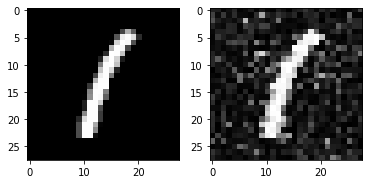

25  :  0.43712486991216315 25
50  :  0.4459769408445462 25
75  :  0.4427084708807828 25
100  :  0.5178317880858951 25
125  :  0.5251735132229494 25
150  :  0.5568271583403398 25
175  :  0.5444531924760957 25
200  :  0.5444531924760957 25
225  :  0.5460277024360013 25
250  :  0.547288721432874 25
275  :  0.5639433505495858 25
300  :  0.560481619178308 25
325  :  0.560481619178308 25
350  :  0.560481619178308 25
375  :  0.5672211562543072 25
400  :  0.5683353707695095 25
425  :  0.5712722761437453 25
450  :  0.5730766918070906 25
475  :  0.5731126998481697 25
500  :  0.575109798857665 25
525  :  0.5786301591580663 25
550  :  0.5777280936532865 25
575  :  0.579036887299681 25
600  :  0.5789847300694815 25
625  :  0.5807667183094868 25
650  :  0.5829249306915258 25
675  :  0.5848909041264166 25
700  :  0.5850285522286616 25
725  :  0.5850285522286616 25
750  :  0.5851942548586259 25
775  :  0.5853961682763026 25
800  :  0.5853961682763026 25
825  :  0.5856573557317417 25
850  :  0.58582236

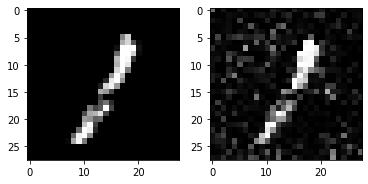

25  :  0.455425088024302 25
50  :  0.5546084728310807 25
75  :  0.550915243591997 25
100  :  0.5506697260682514 25
125  :  0.5464724168474077 25
150  :  0.5448732621264522 25
175  :  0.5504243075628098 25
200  :  0.5601238997363028 25
225  :  0.5599462135458538 25
250  :  0.5665566939196418 25
275  :  0.5675447170646736 25
300  :  0.5667645076695115 25
325  :  0.5674097242998062 25
350  :  0.5681075657747177 25
375  :  0.569920846793138 25
400  :  0.569920846793138 25
425  :  0.569920846793138 25
450  :  0.5705754497622991 25
475  :  0.5710959252830727 25
500  :  0.5713332574578658 25
525  :  0.5717105957503229 25
550  :  0.5718376668295765 25
575  :  0.5726803993193723 25
600  :  0.5726656696937302 25
625  :  0.5731444326699817 25
650  :  0.57419340420932 25
675  :  0.5745844806143668 25
700  :  0.5755563309499468 25
725  :  0.5756535462585062 25
750  :  0.5758733587787177 25
775  :  0.5760643336670608 25
800  :  0.5760643336670608 25
825  :  0.5762856134897789 25
Time:  72.4734461307

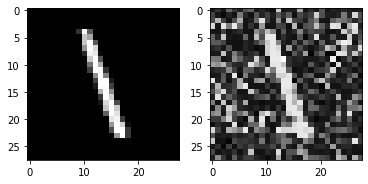

25  :  -0.22337518273385504 25
50  :  0.526874768500971 25
75  :  0.23796858882956734 25
100  :  0.4999421976792669 25
125  :  0.48531020605553654 25
150  :  0.5275263528009992 25
175  :  0.5452647993785743 25
200  :  0.5441242754146436 25
225  :  0.5589351580547383 25
250  :  0.5703880705428754 25
275  :  0.5678183300430683 25
300  :  0.5742427032323694 25
325  :  0.5722401782734842 25
350  :  0.5718092009675173 25
375  :  0.5833136930743906 25
400  :  0.5833136930743906 25
425  :  0.5833136930743906 25
450  :  0.5833136930743906 25
475  :  0.5833136930743906 25
500  :  0.5833136930743906 25
525  :  0.5833136930743906 25
550  :  0.5837347064220012 25
575  :  0.5845298020314005 25
600  :  0.5851379776415103 25
625  :  0.585805485954185 25
650  :  0.5859138357498054 25
675  :  0.5857801672421193 25
700  :  0.5862655749105954 25
725  :  0.5861659058912413 25
750  :  0.5861659058912413 25
775  :  0.5871322603033275 25
800  :  0.5871087383050649 25
825  :  0.5879275279269545 25
850  :  0.5

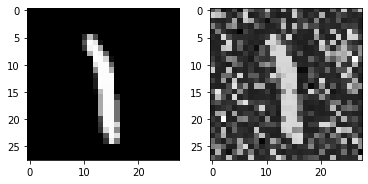

25  :  -0.3798196035124616 25
50  :  -0.3798196035124616 25
75  :  -0.3798196035124616 25
100  :  -0.37805938932149974 25
125  :  -0.3411784959368969 25
150  :  -0.22437293446717135 25
175  :  0.024405992232141197 25
200  :  0.40449145431349876 25
225  :  0.45966768828843596 25
250  :  0.4770462434991624 25
275  :  0.49561473569638154 25
300  :  0.517333599796959 25
325  :  0.5163567307124995 25
350  :  0.535014547989636 25
375  :  0.5343290552345642 25
400  :  0.5331448637279478 25
425  :  0.5331448637279478 25
450  :  0.5331448637279478 25
475  :  0.5331448637279478 25
500  :  0.5351954279823238 25
525  :  0.5331448637279478 25
550  :  0.5331448637279478 25
575  :  0.5331448637279478 25
600  :  0.5403273668878105 25
625  :  0.5331448637279478 25
650  :  0.5333891712454185 25
675  :  0.5331448637279478 25
700  :  0.5366180923404735 25
725  :  0.5366180923404735 25
750  :  0.540583069098511 25
775  :  0.5379730282813278 25
800  :  0.5401050930785982 25
825  :  0.5401050930785982 25
850

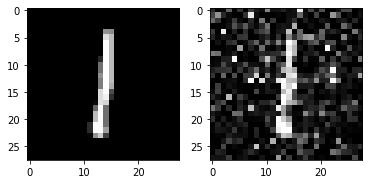

25  :  -0.35888247343517077 25
50  :  -0.35347869617607763 25
75  :  -0.2970499529170138 25
100  :  -0.2426405596059611 25
125  :  -0.06864175673683325 25
150  :  0.27678509430672793 25
175  :  0.4197688487526957 25
200  :  0.429997874756733 25
225  :  0.49327799932828204 25
250  :  0.5260848350436077 25
275  :  0.5195716633006509 25
300  :  0.49379228411435655 25
325  :  0.5034811049940485 25
350  :  0.5400121408676585 25
375  :  0.5408348950297858 25
400  :  0.5408348950297858 25
425  :  0.5467759232374827 25
450  :  0.5703473749939797 25
475  :  0.5706441835298379 25
500  :  0.5706441835298379 25
525  :  0.5726172431422506 25
550  :  0.5770817140232669 25
575  :  0.5773353515047968 25
600  :  0.5822038245132519 25
625  :  0.5842009683313947 25
650  :  0.584569446565737 25
675  :  0.5852086730747317 25
700  :  0.5857318806241911 25
725  :  0.5893096265731369 25
750  :  0.5890204590735298 25
775  :  0.5890204590735298 25
800  :  0.5890204590735298 25
825  :  0.5895422000247283 25
850 

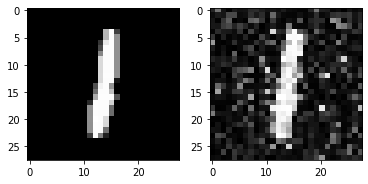

25  :  -0.35961690939873703 25
50  :  -0.35211242155588396 25
75  :  -0.3247833061608879 25
100  :  -0.07654123222059676 25
125  :  0.22540633022243442 25
150  :  0.35833977980211906 25
175  :  0.38558581042375606 25
200  :  0.4223995739411064 25
225  :  0.4454460863441486 25
250  :  0.4859707930573208 25
275  :  0.5110001650117941 25
300  :  0.5174177060368303 25
325  :  0.5130472105450484 25
350  :  0.5130472105450484 25
375  :  0.5130472105450484 25
400  :  0.5130472105450484 25
425  :  0.5145991754703345 25
450  :  0.5226946802822777 25
475  :  0.5379322071046253 25
500  :  0.5416491377997098 25
525  :  0.5420515077432033 25
550  :  0.5483561558550516 25
575  :  0.5597122881135064 25
600  :  0.5611272633466974 25
625  :  0.5617600427379282 25
650  :  0.5617600427379282 25
675  :  0.5617600427379282 25
700  :  0.5629941230216828 25
725  :  0.564025590762496 25
750  :  0.564025590762496 25
775  :  0.5650350791932781 25
800  :  0.5652983916417456 25
825  :  0.5661645627890943 25
850  

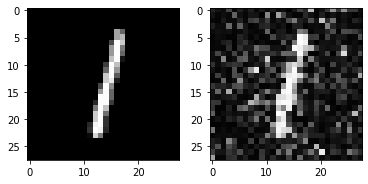

25  :  -0.3565229175855787 25
50  :  -0.2414059034596599 25
75  :  -0.1702865799654024 25
100  :  0.12691752582228946 25
125  :  0.5047133395950127 25
150  :  0.5198338695779774 25
175  :  0.5472961300153395 25
200  :  0.5545585241384678 25
225  :  0.5635555982506107 25
250  :  0.5748871734973983 25
275  :  0.5748871734973983 25
300  :  0.5778930500077311 25
325  :  0.5776820374920411 25
350  :  0.5776820374920411 25
375  :  0.5819571124547132 25
400  :  0.5842185753935233 25
425  :  0.5842215556257621 25
450  :  0.5842215556257621 25
475  :  0.5869338939251756 25
500  :  0.5879254636340178 25
525  :  0.5898217506319222 25
550  :  0.5901477236826745 25
575  :  0.5901477236826745 25
600  :  0.5932352230713966 25
625  :  0.593178853910107 25
650  :  0.5942910230230865 25
675  :  0.5945589744827342 25
700  :  0.5953912656639686 25
725  :  0.5956059432563793 25
750  :  0.5956059432563793 25
775  :  0.5956059432563793 25
800  :  0.5956194918537421 25
825  :  0.5963014955118745 25
850  :  0.

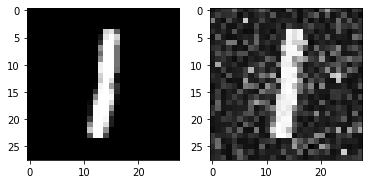

25  :  -0.21887210237155488 25
50  :  0.061369541942916286 25
75  :  0.23931177587709285 25
100  :  0.36239595986364304 25
125  :  0.44050387152061415 25
150  :  0.4491695349946827 25
175  :  0.4491695349946827 25
200  :  0.4672363260242895 25
225  :  0.4891079317187748 25
250  :  0.4913650164119774 25
275  :  0.516651606356291 25
300  :  0.5284605681083223 25
325  :  0.5491415921022507 25
350  :  0.5510059327278493 25
375  :  0.5632246917349163 25
400  :  0.5676191435800784 25
425  :  0.570563397145742 25
450  :  0.5755332713256107 25
475  :  0.5762692171583826 25
500  :  0.5771125475446116 25
525  :  0.5772604042855173 25
550  :  0.5795621248540815 25
575  :  0.5796662457747288 25
600  :  0.5807702184698554 25
625  :  0.5836891148189332 25
650  :  0.5840851761266868 25
675  :  0.5844085230917928 25
700  :  0.5855580076995623 25
725  :  0.5865674170138527 25
750  :  0.58680612101266 25
775  :  0.5868898883572549 25
800  :  0.5879520646075086 25
825  :  0.58852955690063 25
850  :  0.58

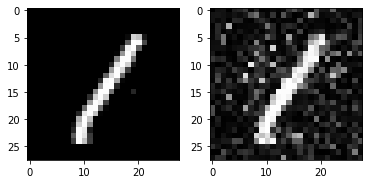

25  :  -0.3550255411662052 25
50  :  -0.334137480439478 25
75  :  -0.353548193020046 25
100  :  -0.31522952028338314 25
125  :  -0.14239424451997948 25
150  :  0.2823986566484198 25
175  :  0.5306541702513262 25
200  :  0.5372406685755141 25
225  :  0.5372406685755141 25
250  :  0.5372406685755141 25
275  :  0.5372406685755141 25
300  :  0.5471003503561463 25
325  :  0.5471003503561463 25
350  :  0.555113632345676 25
375  :  0.557241851890256 25
400  :  0.557241851890256 25
425  :  0.5628853866780293 25
450  :  0.5693934683279099 25
475  :  0.5759569965128004 25
500  :  0.5755542897059863 25
525  :  0.5780603727563359 25
550  :  0.578743411053759 25
575  :  0.580111692540215 25
600  :  0.5803592464347723 25
625  :  0.5825254556312269 25
650  :  0.5828323225678828 25
675  :  0.5832685342815477 25
700  :  0.5834559464237685 25
725  :  0.5837104913435174 25
750  :  0.5856473228425776 25
775  :  0.5856005782289257 25
800  :  0.585724455270902 25
825  :  0.5860510775607081 25
850  :  0.5862

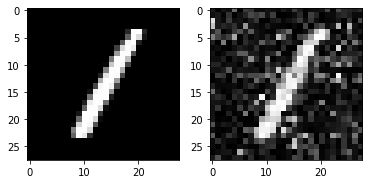

25  :  -0.315674748491496 25
50  :  -0.29418986142374837 25
75  :  -0.31633887678976214 25
100  :  -0.31633887678976214 25
125  :  -0.31633887678976214 25
150  :  -0.31633887678976214 25
175  :  -0.31633887678976214 25
200  :  -0.31633887678976214 25
225  :  -0.31633887678976214 25
250  :  -0.31633887678976214 25
275  :  -0.31633887678976214 25
300  :  -0.31633887678976214 25
325  :  -0.31633887678976214 25
350  :  -0.31633887678976214 25
375  :  -0.31633887678976214 25
400  :  -0.31633887678976214 25
425  :  -0.31633887678976214 25
450  :  -0.31633887678976214 25
475  :  -0.31633887678976214 25
500  :  -0.31633887678976214 25
525  :  -0.31633887678976214 25
550  :  -0.31633887678976214 25
575  :  -0.31633887678976214 25
600  :  -0.31633887678976214 25
625  :  -0.31633887678976214 25
650  :  -0.31633887678976214 25
675  :  -0.31633887678976214 25
700  :  -0.31633887678976214 25
725  :  -0.31633887678976214 25
750  :  -0.31633887678976214 25
775  :  -0.31633887678976214 25
800  :  -0.31

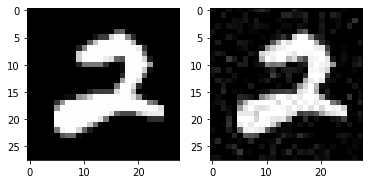

25  :  -0.2875197105423162 25
50  :  0.14062552401922668 25
75  :  -0.30015699891349956 25
100  :  -0.29869564726618736 25
125  :  -0.29200005403273477 25
150  :  -0.2780867959767753 25
175  :  -0.2821565416215393 25
200  :  -0.21293275968334216 25
225  :  0.16456288352015 25
250  :  0.2868462855747399 25
275  :  0.5539343290575787 25
300  :  0.5693705675951072 25
325  :  0.5784101983258091 25
350  :  0.5781393109482473 25
375  :  0.5887261619542441 25
400  :  0.5991729163468034 25
425  :  0.5996494722326828 25
450  :  0.5996494722326828 25
475  :  0.604176756853015 25
500  :  0.6024075042054994 25
525  :  0.6052148035450429 25
550  :  0.6078119184782166 25
575  :  0.6087180015266592 25
600  :  0.6088384203344082 25
625  :  0.6095467163897735 25
650  :  0.6100806509911179 25
675  :  0.6114208733870842 25
700  :  0.6114736905526511 25
725  :  0.6120028713084233 25
750  :  0.613058276282527 25
775  :  0.6134432000221239 25
800  :  0.6149259983014921 25
825  :  0.61492437173802 25
850  : 

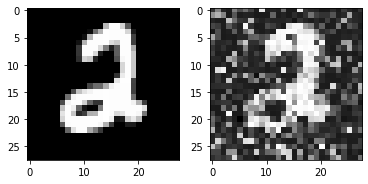

25  :  -0.07576311637312919 25
50  :  -0.07576311637312919 25
75  :  -0.0729794044824836 25
100  :  -0.06017847278045993 25
125  :  0.009868647698432376 25
150  :  0.003003543068712422 25
175  :  0.09116428561513423 25
200  :  0.2784350293779727 25
225  :  0.3531470976473905 25
250  :  0.42975939395212537 25
275  :  0.4421711642545352 25
300  :  0.4149975418602476 25
325  :  0.4435115468502732 25
350  :  0.48080863155361553 25
375  :  0.4926151983394304 25
400  :  0.4914090528938247 25
425  :  0.5218390507193083 25
450  :  0.531105464821452 25
475  :  0.531105464821452 25
500  :  0.5333331434081588 25
525  :  0.5385528597341448 25
550  :  0.5437835091679353 25
575  :  0.5594576516245339 25
600  :  0.5594576516245339 25
625  :  0.5613122758664407 25
650  :  0.568474898406131 25
675  :  0.5756616224455972 25
700  :  0.5790425297884089 25
725  :  0.5770925938144124 25
750  :  0.5809824196795532 25
775  :  0.5809824196795532 25
800  :  0.5809824196795532 25
825  :  0.5870156603014268 25
85

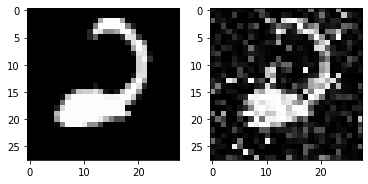

25  :  -0.28795101224765596 25
50  :  -0.28795101224765596 25
75  :  -0.28795101224765596 25
100  :  -0.27070979634262726 25
125  :  -0.2734005116521254 25
150  :  -0.27159910041373014 25
175  :  -0.2546993052870816 25
200  :  -0.20948011999529603 25
225  :  -0.11126804910238633 25
250  :  0.3106577128869954 25
275  :  0.5267135901534865 25
300  :  0.5349719844778837 25
325  :  0.5390784455283435 25
350  :  0.5291519058702854 25
375  :  0.5363358106694158 25
400  :  0.5407370154780691 25
425  :  0.5442297630741828 25
450  :  0.5475510317438264 25
475  :  0.5494538210136493 25
500  :  0.5498865697177833 25
525  :  0.5475087000526884 25
550  :  0.5511163262669019 25
575  :  0.5529935262948742 25
600  :  0.5544576587907909 25
625  :  0.5558877894514535 25
650  :  0.5561038905495796 25
675  :  0.5556219079999852 25
700  :  0.5578847920466451 25
725  :  0.5587826110890262 25
750  :  0.5604781798916041 25
775  :  0.562272762585996 25
800  :  0.5646645358894659 25
825  :  0.5651514853840381 2

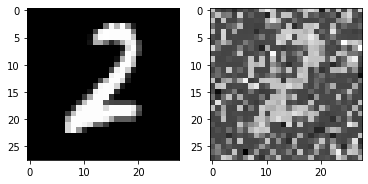

25  :  0.4671998058782684 25
50  :  0.5728687153553551 25
75  :  0.5402873499364969 25
100  :  0.5522203339073789 25
125  :  0.5471014810951148 25
150  :  0.5553859678585451 25
175  :  0.5613089050755872 25
200  :  0.5682548676803871 25
225  :  0.5715579052323699 25
250  :  0.5791113602210475 25
275  :  0.5826367310240843 25
300  :  0.5831923966815844 25
325  :  0.5837035773977762 25
350  :  0.5866963342483015 25
375  :  0.5869931157554651 25
400  :  0.5879826909257153 25
425  :  0.5891206607342175 25
450  :  0.5892688465974625 25
475  :  0.589822789445024 25
500  :  0.5915837286452698 25
525  :  0.594016755400867 25
550  :  0.5943828991836766 25
575  :  0.5951048148720689 25
600  :  0.5967865728864787 25
625  :  0.5979139501421934 25
650  :  0.5978624560622082 25
675  :  0.5991716892188834 25
700  :  0.5997390175506991 25
725  :  0.6006015289626326 25
750  :  0.60098274193508 25
775  :  0.602249660661433 25
800  :  0.6022596549833636 25
825  :  0.602818995198197 25
850  :  0.603246347

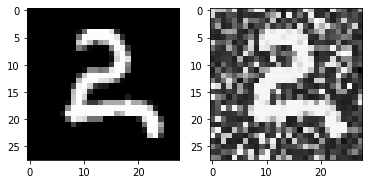

25  :  0.03591977949397984 25
50  :  0.051700000366212806 25
75  :  0.13552928034124737 25
100  :  0.16173111307524352 25
125  :  0.24307526344795208 25
150  :  0.32763421675634397 25
175  :  0.3860277384518067 25
200  :  0.4869597738586785 25
225  :  0.5371794425183576 25
250  :  0.5623692220908292 25
275  :  0.5642998562117075 25
300  :  0.5692796946028854 25
325  :  0.5753949902341312 25
350  :  0.5841987689650213 25
375  :  0.5873170754551988 25
400  :  0.5914506381132617 25
425  :  0.5922352092498111 25
450  :  0.5973030222547575 25
475  :  0.5971521060063014 25
500  :  0.6000293071446594 25
525  :  0.6033290954958936 25
550  :  0.6057322183459813 25
575  :  0.6054805562003214 25
600  :  0.6090911101193862 25
625  :  0.6097269009695817 25
650  :  0.6103559078127114 25
675  :  0.6107290581779103 25
700  :  0.6108432924068813 25
725  :  0.6127275325273205 25
750  :  0.6129980061846272 25
775  :  0.6134864364043092 25
800  :  0.6140514332427613 25
825  :  0.6141557610028947 25
850  :

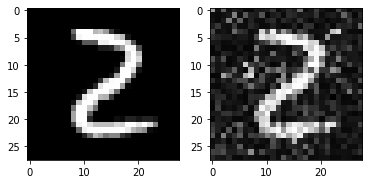

25  :  -0.21699520322742047 25
50  :  0.2906618676700985 25
75  :  -0.13014045218628548 25
100  :  -0.05362221488132826 25
125  :  0.055153488243584375 25
150  :  0.4162786392886412 25
175  :  0.3705143276189634 25
200  :  0.5302141905871027 25
225  :  0.5695576992134375 25
250  :  0.5619407222813259 25
275  :  0.5631950880779341 25
300  :  0.5619407222813259 25
325  :  0.5792253055154667 25
350  :  0.5792253055154667 25
375  :  0.5903291949853301 25
400  :  0.5920487726992338 25
425  :  0.5952187965929235 25
450  :  0.5952187965929235 25
475  :  0.5972981515457676 25
500  :  0.6000306782239846 25
525  :  0.6031372703879156 25
550  :  0.6047019291095798 25
575  :  0.6112510930204794 25
600  :  0.6111584710498658 25
625  :  0.612230891267014 25
650  :  0.6150305280502048 25
675  :  0.6154426190740243 25
700  :  0.6167132932058105 25
725  :  0.6166113178998057 25
750  :  0.6193876125783682 25
775  :  0.6196536901417768 25
800  :  0.6214322687878686 25
825  :  0.6214503849907902 25
850  :

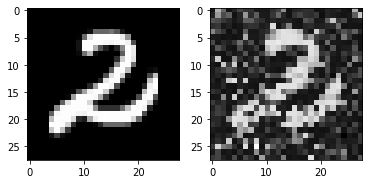

25  :  -0.0532054287471074 25
50  :  0.3110098984445052 25
75  :  -0.05248536148047847 25
100  :  0.03927625802016879 25
125  :  0.0350424129378408 25
150  :  0.23774763388989723 25
175  :  0.42741822336372515 25
200  :  0.4829948108204579 25
225  :  0.5085303115231707 25
250  :  0.5290796991536316 25
275  :  0.5540657593400304 25
300  :  0.5511223056829101 25
325  :  0.5511223056829101 25
350  :  0.5600774133286681 25
375  :  0.5655251126037236 25
400  :  0.5710273307201484 25
425  :  0.5710273307201484 25
450  :  0.5710273307201484 25
475  :  0.5710273307201484 25
500  :  0.5754291874127386 25
525  :  0.5787588735737872 25
550  :  0.5785426152016903 25
575  :  0.5804388815918355 25
600  :  0.5815974201236502 25
625  :  0.5832353160538382 25
650  :  0.5847571577971042 25
675  :  0.5880728679600136 25
700  :  0.5869900569599186 25
725  :  0.587685086939078 25
750  :  0.5891567401913498 25
775  :  0.5898429619814076 25
800  :  0.5906896050449382 25
825  :  0.5930002015698377 25
850  :  

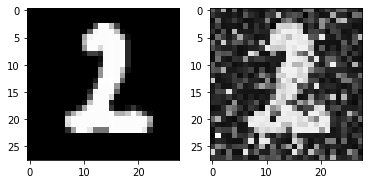

25  :  -0.3186852119124042 25
50  :  -0.300178391858836 25
75  :  -0.3186852119124042 25
100  :  -0.3186852119124042 25
125  :  -0.3186852119124042 25
150  :  -0.31701365247897206 25
175  :  -0.31415768607648076 25
200  :  -0.3093383980188528 25
225  :  -0.29025323153826166 25
250  :  -0.25763470235445185 25
275  :  -0.12189965033092456 25
300  :  0.15703054226537172 25
325  :  0.5302112810711274 25
350  :  0.5651788830646063 25
375  :  0.5721335068985813 25
400  :  0.5608288649016943 25
425  :  0.5608288649016943 25
450  :  0.5721808389895041 25
475  :  0.5746522031431529 25
500  :  0.5809336680500885 25
525  :  0.5819147683918249 25
550  :  0.5824079109071413 25
575  :  0.5824079109071413 25
600  :  0.5824079109071413 25
625  :  0.5841174914690845 25
650  :  0.5888897760717352 25
675  :  0.5903452549499959 25
700  :  0.5904838939040207 25
725  :  0.5910429571394128 25
750  :  0.5917144600459211 25
775  :  0.5918073221588311 25
800  :  0.5941596515706129 25
825  :  0.5944792874552123 

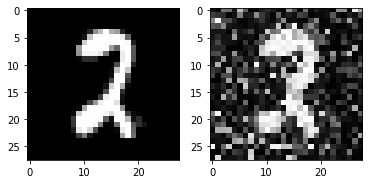

25  :  -0.22534869975543945 25
50  :  -0.026417123796015962 25
75  :  -0.14363152703879623 25
100  :  -0.011167842312998583 25
125  :  0.3050774064487417 25
150  :  0.3948543981172051 25
175  :  0.4896645159751314 25
200  :  0.5381753479119735 25
225  :  0.5506417324288303 25
250  :  0.5597343782590356 25
275  :  0.5664800150449041 25
300  :  0.5669321780700359 25
325  :  0.5697442471830337 25
350  :  0.5737957532969151 25
375  :  0.5738775494835049 25
400  :  0.5786527903497213 25
425  :  0.5796146602808859 25
450  :  0.5796146602808859 25
475  :  0.5822567293203127 25
500  :  0.5829931574468481 25
525  :  0.5830287300923376 25
550  :  0.5830287300923376 25
575  :  0.5838399290537661 25
600  :  0.5838399290537661 25
625  :  0.5838399290537661 25
650  :  0.5838399290537661 25
675  :  0.5852882242621428 25
700  :  0.5878713545925163 25
725  :  0.5879011830157896 25
750  :  0.5896168058529578 25
775  :  0.5898307455418591 25
800  :  0.5918614659426238 25
825  :  0.5927798060713373 25
850

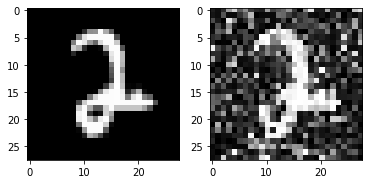

25  :  -0.3170751713307398 25
50  :  -0.3170751713307398 25
75  :  -0.3170751713307398 25
100  :  -0.3170751713307398 25
125  :  -0.3170751713307398 25
150  :  -0.3170751713307398 25
175  :  -0.3160800801197028 25
200  :  -0.3160800801197028 25
225  :  -0.315019022810082 25
250  :  -0.3132891726355298 25
275  :  -0.3130420933639521 25
300  :  -0.30998794011139597 25
325  :  -0.30197677073869644 25
350  :  -0.28536451715674405 25
375  :  -0.27118723131726685 25
400  :  -0.22240145619789023 25
425  :  0.03973473596660354 25
450  :  0.02338514345176787 25
475  :  0.2001526914775783 25
500  :  0.5153276794130282 25
525  :  0.5690859101606934 25
550  :  0.5615043560307317 25
575  :  0.5585087506808114 25
600  :  0.5584779349477358 25
625  :  0.5611296716325788 25
650  :  0.5561516453539788 25
675  :  0.5553601780643403 25
700  :  0.5654531406939882 25
725  :  0.5638791182842711 25
750  :  0.5633858064041286 25
775  :  0.5687420251462519 25
800  :  0.5709845162917179 25
825  :  0.57073009170

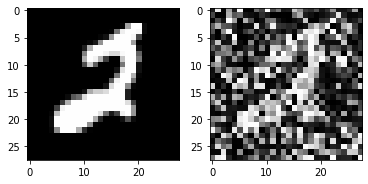

25  :  0.3563342354096437 25
50  :  0.3563342354096437 25
75  :  0.44837339524885245 25
100  :  0.39714072360422903 25
125  :  0.4454339570288512 25
150  :  0.44114310948228663 25
175  :  0.5074948233750187 25
200  :  0.541580004417784 25
225  :  0.560501974508332 25
250  :  0.5611295639543821 25
275  :  0.5855009958267744 25
300  :  0.5852465413411652 25
325  :  0.5852465413411652 25
350  :  0.5852465413411652 25
375  :  0.5852465413411652 25
400  :  0.5852465413411652 25
425  :  0.5852465413411652 25
450  :  0.5881620418273369 25
475  :  0.5884382753132553 25
500  :  0.5884382753132553 25
525  :  0.5885982884342615 25
550  :  0.5945492802593264 25
575  :  0.5945492802593264 25
600  :  0.597408339713592 25
625  :  0.5974169936660063 25
650  :  0.5978705712736326 25
675  :  0.5985616910180125 25
700  :  0.6005447614796388 25
725  :  0.6005447614796388 25
750  :  0.6021642495207842 25
775  :  0.6021553557846121 25
800  :  0.603110917327222 25
825  :  0.6048147131562261 25
850  :  0.6056

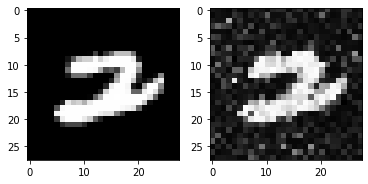

25  :  0.47757278911601364 25
50  :  0.549850399500865 25
75  :  0.5096459084989621 25
100  :  0.5388867642129042 25
125  :  0.5576446667454674 25
150  :  0.5562187464821993 25
175  :  0.5588039841529187 25
200  :  0.5665594191050703 25
225  :  0.5678935583091792 25
250  :  0.5806972262181532 25
275  :  0.5877722763050183 25
300  :  0.5830299201780205 25
325  :  0.5849199251644831 25
350  :  0.5886655438287195 25
375  :  0.5886850895937056 25
400  :  0.5894964510616981 25
425  :  0.5886850895937056 25
450  :  0.5911404354477724 25
475  :  0.5927049523422583 25
500  :  0.5931271916858134 25
525  :  0.5931271916858134 25
550  :  0.594412225033488 25
575  :  0.5947625786410506 25
600  :  0.5959280237411791 25
625  :  0.595548728642818 25
650  :  0.595548728642818 25
675  :  0.5961947766941806 25
700  :  0.596783846983783 25
725  :  0.5979019133856069 25
750  :  0.5988682470083537 25
775  :  0.5989328101604983 25
800  :  0.5989328101604983 25
825  :  0.5991503149641951 25
850  :  0.5991503

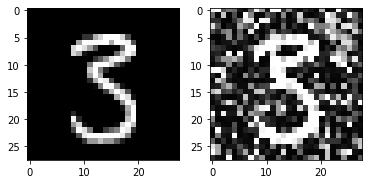

25  :  -0.050283218702889876 25
50  :  0.4979470155070702 25
75  :  -0.16917373894822144 25
100  :  -0.1903949763690142 25
125  :  -0.31887761545883464 25
150  :  -0.31887761545883464 25
175  :  -0.31887761545883464 25
200  :  -0.1797016170040469 25
225  :  -0.31887761545883464 25
250  :  -0.3167894016306991 25
275  :  -0.31682603340403803 25
300  :  -0.31682603340403803 25
325  :  -0.31682603340403803 25
350  :  -0.31682603340403803 25
375  :  -0.31682603340403803 25
400  :  -0.31682603340403803 25
425  :  -0.31682603340403803 25
450  :  -0.31625481690260204 25
475  :  -0.3162372745704771 25
500  :  -0.31586397462901483 25
525  :  -0.31553152859638206 25
550  :  -0.3153942568384001 25
575  :  -0.31488209611976337 25
600  :  -0.31486211855466817 25
625  :  -0.31486211855466817 25
650  :  -0.31481435201635544 25
675  :  -0.31481435201635544 25
700  :  -0.31481435201635544 25
725  :  -0.31481435201635544 25
750  :  -0.31468968297746014 25
775  :  -0.3146301317377441 25
800  :  -0.3144530

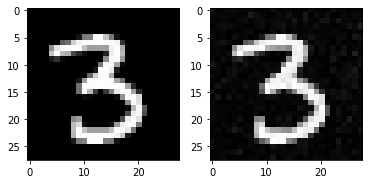

25  :  -0.16425594630148826 25
50  :  0.482017419442439 25
75  :  -0.3027326562382066 25
100  :  -0.036783802117866846 25
125  :  -0.3027326562382066 25
150  :  -0.3027326562382066 25
175  :  -0.3027326562382066 25
200  :  -0.3027326562382066 25
225  :  -0.3027326562382066 25
250  :  -0.3027326562382066 25
275  :  -0.3027326562382066 25
300  :  -0.3027326562382066 25
325  :  -0.3027326562382066 25
350  :  -0.3027326562382066 25
375  :  -0.3027326562382066 25
400  :  -0.3027326562382066 25
425  :  -0.3027326562382066 25
450  :  -0.3027326562382066 25
475  :  -0.3027326562382066 25
500  :  -0.3025413230397138 25
525  :  -0.3025388922563391 25
550  :  -0.3025388922563391 25
575  :  -0.3025388922563391 25
600  :  -0.3025388922563391 25
625  :  -0.3025388922563391 25
650  :  -0.3025388922563391 25
675  :  -0.3025388922563391 25
700  :  -0.3018146682473154 25
725  :  -0.30172575460857753 25
750  :  -0.30125536647970375 25
775  :  -0.30061439186039124 25
800  :  -0.3006424118171481 25
825  : 

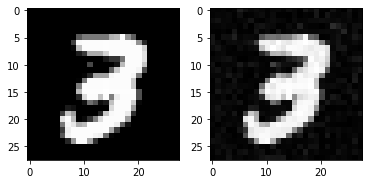

25  :  -0.13435282946050475 25
50  :  0.2228824584690404 25
75  :  -0.3083792343539806 25
100  :  -0.3083792343539806 25
125  :  -0.3083792343539806 25
150  :  -0.3083792343539806 25
175  :  -0.3083792343539806 25
200  :  -0.3083792343539806 25
225  :  -0.3083792343539806 25
250  :  -0.3083792343539806 25
275  :  -0.3083792343539806 25
300  :  -0.30837923435396625 25
325  :  -0.30837923435396625 25
350  :  -0.30837923435396625 25
375  :  -0.30837923435396625 25
400  :  -0.30837923435396625 25
425  :  -0.30837923435396625 25
450  :  -0.30837923435396625 25
475  :  -0.30837923435396625 25
500  :  -0.30837923435396625 25
525  :  -0.30837923435396625 25
550  :  -0.30837923435396625 25
575  :  -0.30837923435396625 25
600  :  -0.30837923435396625 25
625  :  -0.30837923435396625 25
650  :  -0.30837923435396625 25
675  :  -0.30837923435396625 25
700  :  -0.30837923435396625 25
725  :  -0.30837923435396625 25
750  :  -0.30837923435396625 25
775  :  -0.30837923435396625 25
800  :  -0.30837923435

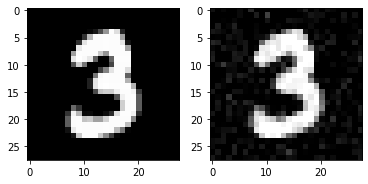

25  :  0.010846566557748488 25
50  :  0.5420983508862052 25
75  :  0.36252253808690416 25
100  :  0.4393684975563195 25
125  :  0.46648939330526173 25
150  :  0.47721175414565276 25
175  :  0.5401179912098563 25
200  :  0.5611362717788145 25
225  :  0.5521197978913326 25
250  :  0.5545430250916191 25
275  :  0.5759024819856117 25
300  :  0.5752816680676955 25
325  :  0.5806593694277835 25
350  :  0.5817734356728202 25
375  :  0.5817734356728202 25
400  :  0.5834989726547759 25
425  :  0.5828737976457874 25
450  :  0.5840047542133077 25
475  :  0.5840047542133077 25
500  :  0.5840047542133077 25
525  :  0.5845473268850733 25
550  :  0.5868497933466448 25
575  :  0.5880939567745651 25
600  :  0.5881853480277472 25
625  :  0.5890253831155567 25
650  :  0.5891556801509243 25
675  :  0.5906960008999981 25
700  :  0.5907707074359814 25
725  :  0.5911377077638964 25
750  :  0.5912154976366796 25
775  :  0.5922071757393448 25
800  :  0.5924389675159065 25
825  :  0.5926797170998798 25
850  :  

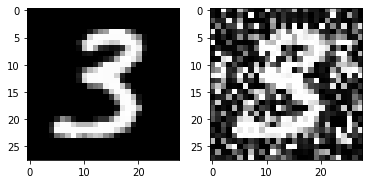

25  :  -0.3155736550507885 25
50  :  0.28129359348653715 25
75  :  -0.3036460320976601 25
100  :  -0.15240974839275245 25
125  :  -0.32221236317808294 25
150  :  -0.32938245420342155 25
175  :  -0.33131946266777124 25
200  :  -0.2880772803193232 25
225  :  -0.3441828412652129 25
250  :  -0.3441828412652129 25
275  :  -0.3441828412652129 25
300  :  -0.3441828412652129 25
325  :  -0.3441828412652129 25
350  :  -0.3441828412652129 25
375  :  -0.3441828412652129 25
400  :  -0.3441828412652129 25
425  :  -0.3441828412652129 25
450  :  -0.3441828412652129 25
475  :  -0.3441828412652129 25
500  :  -0.3441828412652129 25
525  :  -0.3441828412652129 25
550  :  -0.3441828412652129 25
575  :  -0.3441828412652129 25
600  :  -0.3441828412652129 25
625  :  -0.3441828412652129 25
650  :  -0.3441828412651885 25
675  :  -0.3441828412651885 25
700  :  -0.3441828412651885 25
725  :  -0.3441828412651885 25
750  :  -0.3441828412651885 25
775  :  -0.3441828412651885 25
800  :  -0.3441828412651885 25
825  : 

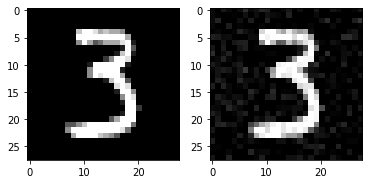

25  :  -0.3226423885381632 25
50  :  -0.3226423885381632 25
75  :  -0.3226423885381632 25
100  :  -0.3226423885381632 25
125  :  -0.3226423885381632 25
150  :  -0.3226423885381632 25
175  :  -0.3226423885381632 25
200  :  -0.3226423885381632 25
225  :  -0.3226423885381632 25
250  :  -0.3226423885381632 25
275  :  -0.3226423885381632 25
300  :  -0.3226423885381632 25
325  :  -0.3226423885381632 25
350  :  -0.3226423885381632 25
375  :  -0.3226423885381632 25
400  :  -0.3226423885381632 25
425  :  -0.3226423885381632 25
450  :  -0.3226423885381632 25
475  :  -0.3226423885381632 25
500  :  -0.3226423885381632 25
525  :  -0.3226423885381632 25
550  :  -0.3226423885381632 25
575  :  -0.3226423885381632 25
600  :  -0.3226423885381632 25
625  :  -0.3226423885381632 25
650  :  -0.3226423885381632 25
675  :  -0.3226423885381632 25
700  :  -0.3226423885381632 25
725  :  -0.3226423885381632 25
750  :  -0.3226423885381632 25
775  :  -0.3226423885381632 25
800  :  -0.3226423885381632 25
Time:  66.1

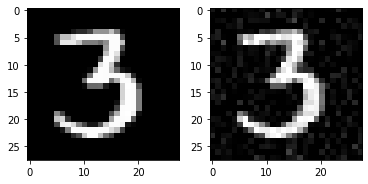

25  :  -0.30140070694421944 25
50  :  0.22730096432917946 25
75  :  -0.3150641037620311 25
100  :  -0.33193052517630905 25
125  :  -0.33193052517630905 25
150  :  -0.33193052517630905 25
175  :  -0.33193052517630905 25
200  :  -0.33193052517630905 25
225  :  -0.33193052517630905 25
250  :  -0.33193052517630905 25
275  :  -0.33193052517630905 25
300  :  -0.33193052517630905 25
325  :  -0.33193052517630905 25
350  :  -0.33193052517630905 25
375  :  -0.3315173446589741 25
400  :  -0.331152245483842 25
425  :  -0.3302449518146054 25
450  :  -0.33024507102363787 25
475  :  -0.3299155164787593 25
500  :  -0.3298023027249256 25
525  :  -0.32976083475407225 25
550  :  -0.3296783846388547 25
575  :  -0.3294258536973237 25
600  :  -0.3294258536973237 25
625  :  -0.3292436270623388 25
650  :  -0.3292436270623388 25
675  :  -0.3290047274431346 25
700  :  -0.32900543482982636 25
725  :  -0.3289803429877828 25
750  :  -0.3289055666114782 25
775  :  -0.3289055666114782 25
800  :  -0.32879430333293996

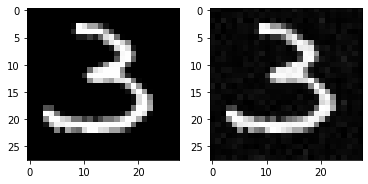

25  :  0.6155891770486954 25
50  :  0.6179165518315437 25
75  :  0.6114487602289691 25
100  :  0.6090836273223921 25
125  :  0.6082843602246232 25
150  :  0.6098074394076524 25
175  :  0.6021022255140882 25
200  :  0.6036579695656117 25
225  :  0.6065335370933524 25
250  :  0.6224543636234404 25
275  :  0.6235661933963375 25
300  :  0.6214142332813586 25
325  :  0.6238883252627556 25
350  :  0.6241867592043577 25
375  :  0.6283966043919605 25
400  :  0.6283966043919605 25
425  :  0.6287119286059126 25
450  :  0.6297223254839917 25
475  :  0.6316525613832928 25
500  :  0.6359570823931073 25
525  :  0.6359570823931073 25
550  :  0.6368832568711682 25
575  :  0.6368809866179024 25
600  :  0.6379089072843928 25
625  :  0.6382221818252412 25
650  :  0.63860746484857 25
675  :  0.6397564110963319 25
700  :  0.6397501763707751 25
725  :  0.6421004338286185 25
750  :  0.6422342283978113 25
775  :  0.6428287663252161 25
800  :  0.6432015805587712 25
825  :  0.643741379483277 25
850  :  0.644142

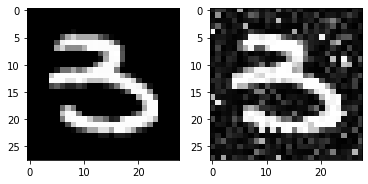

25  :  -0.11686665763830067 25
50  :  -0.11686665763830067 25
75  :  -0.07061679094836343 25
100  :  -0.01818705487041747 25
125  :  0.023993896710256507 25
150  :  0.05984429721365914 25
175  :  0.11523283173053281 25
200  :  0.29206231052943105 25
225  :  0.329087276748774 25
250  :  0.4030348998364927 25
275  :  0.46843321743347055 25
300  :  0.47514844823881364 25
325  :  0.5386557021683829 25
350  :  0.5372872919109187 25
375  :  0.5496282168535359 25
400  :  0.5447068971706083 25
425  :  0.5447068971706083 25
450  :  0.553096319830882 25
475  :  0.553096319830882 25
500  :  0.55437313694043 25
525  :  0.5552071896319037 25
550  :  0.5581406728073913 25
575  :  0.560560232695521 25
600  :  0.5661034228200384 25
625  :  0.5694928457031591 25
650  :  0.5709239208926865 25
675  :  0.5709239208926865 25
700  :  0.5709239208926865 25
725  :  0.5720743853522388 25
750  :  0.5741426903163293 25
775  :  0.5765617803475518 25
800  :  0.5765401124357112 25
825  :  0.5769793055289412 25
850 

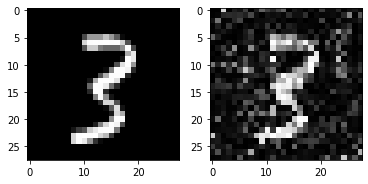

25  :  -0.30884155828284654 25
50  :  -0.29814010617160197 25
75  :  -0.3229253334969826 25
100  :  -0.3229253334969826 25
125  :  -0.3229253334969826 25
150  :  -0.3229253334969826 25
175  :  -0.3229253334969826 25
200  :  -0.3229253334969826 25
225  :  -0.3229253334969826 25
250  :  -0.3229253334969826 25
275  :  -0.3229253334969826 25
300  :  -0.3229253334969826 25
325  :  -0.3225369102475475 25
350  :  -0.3221704315269982 25
375  :  -0.32190095754858017 25
400  :  -0.3220328222148808 25
425  :  -0.32203334680875967 25
450  :  -0.32174551966555487 25
475  :  -0.32163620475005816 25
500  :  -0.32163620475005816 25
525  :  -0.32149499880925125 25
550  :  -0.3209062120010252 25
575  :  -0.3209105686711306 25
600  :  -0.3209105686711306 25
625  :  -0.3209105686711306 25
650  :  -0.3209105686711306 25
675  :  -0.3208846671846237 25
700  :  -0.3208148389630862 25
725  :  -0.3207133444123256 25
750  :  -0.3206735194292123 25
775  :  -0.32065590068906724 25
800  :  -0.3205748592314684 25
82

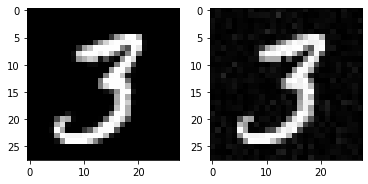

25  :  0.20090328513479924 25
50  :  0.5707026704020126 25
75  :  0.3787095179328424 25
100  :  0.2097325308158008 25
125  :  -0.29338144981039027 25
150  :  0.12759491744538717 25
175  :  -0.29338144981039027 25
200  :  -0.29338144981039027 25
225  :  -0.29338144981039027 25
250  :  -0.29338144981039027 25
275  :  -0.29338144981039027 25
300  :  -0.29338144981039027 25
325  :  -0.29338144981039027 25
350  :  -0.29338144981039027 25
375  :  -0.29338144981039027 25
400  :  -0.29338144981039027 25
425  :  -0.29338144981039027 25
450  :  -0.29338144981039027 25
475  :  -0.29338144981039027 25
500  :  -0.29338144981039027 25
525  :  -0.29338144981039027 25
550  :  -0.29338144981039027 25
575  :  -0.29338144981039027 25
600  :  -0.29338144981039027 25
625  :  -0.29338144981039027 25
650  :  -0.29338144981039027 25
675  :  -0.29338144981039027 25
700  :  -0.29338144981039027 25
725  :  -0.29338144981039027 25
750  :  -0.29338144981039027 25
775  :  -0.29338144981039027 25
800  :  -0.29338144

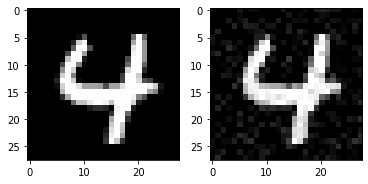

25  :  -0.16206192881417442 25
50  :  0.5601342855068503 25
75  :  0.4535948563378317 25
100  :  0.5081682848438716 25
125  :  0.5403491150651569 25
150  :  0.5669596147311207 25
175  :  0.5759477315752398 25
200  :  0.5740971585650727 25
225  :  0.5745158509919779 25
250  :  0.5788243351380363 25
275  :  0.589079729888778 25
300  :  0.5939068847004028 25
325  :  0.5993735820170318 25
350  :  0.6037282810547016 25
375  :  0.6041272422641082 25
400  :  0.6055782533453374 25
425  :  0.6077561538152788 25
450  :  0.6076964754127885 25
475  :  0.6076964754127885 25
500  :  0.607796372865976 25
525  :  0.6079141402001232 25
550  :  0.6086638464137719 25
575  :  0.6114163301300686 25
600  :  0.6136935111356915 25
625  :  0.6138719560531193 25
650  :  0.6140833937768106 25
675  :  0.6154572437075524 25
700  :  0.6151441822498411 25
725  :  0.6161744684490557 25
750  :  0.6175190723721768 25
775  :  0.6174391178660804 25
800  :  0.6179883805982568 25
825  :  0.6184027524302148 25
850  :  0.617

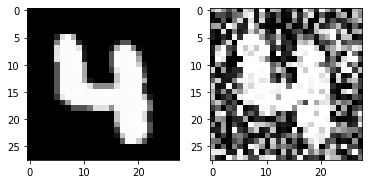

25  :  -0.04565137783118095 25
50  :  0.47968827308207374 25
75  :  0.24826727934724363 25
100  :  0.16230111232896877 25
125  :  0.4939657617565676 25
150  :  0.5032007212235048 25
175  :  0.5396451808296954 25
200  :  0.5563464878643504 25
225  :  0.5550146249556839 25
250  :  0.5569538921691628 25
275  :  0.5719124191620655 25
300  :  0.5747390999496726 25
325  :  0.5741159309456099 25
350  :  0.5770965731601807 25
375  :  0.582437445068741 25
400  :  0.5866375347854518 25
425  :  0.5876555715262681 25
450  :  0.5887566248678275 25
475  :  0.59822952362927 25
500  :  0.5988037414210545 25
525  :  0.5988037414210545 25
550  :  0.5988037414210545 25
575  :  0.599055449134738 25
600  :  0.6006669538128255 25
625  :  0.6021275868760387 25
650  :  0.602165083821461 25
675  :  0.602165083821461 25
700  :  0.6027489826107479 25
725  :  0.6026466914635817 25
750  :  0.6046254995474994 25
775  :  0.6048127896803082 25
800  :  0.6046863985527372 25
825  :  0.6065016201175935 25
850  :  0.6072

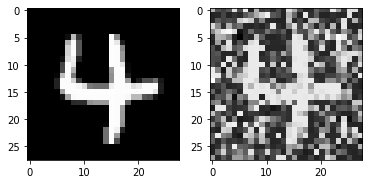

25  :  -0.26280540330125074 25
50  :  0.30482664394305 25
75  :  -0.2551667799914449 25
100  :  0.5511607309187295 25
125  :  0.3805363387988985 25
150  :  0.567265679294228 25
175  :  0.5799665623975527 25
200  :  0.5743790964111004 25
225  :  0.5835268466153535 25
250  :  0.5877866408441818 25
275  :  0.5934313068241369 25
300  :  0.6033917380063585 25
325  :  0.5950947177715257 25
350  :  0.5992339432302929 25
375  :  0.6007141541524472 25
400  :  0.6007141541524472 25
425  :  0.6053590182102264 25
450  :  0.6039167849393419 25
475  :  0.6039167849393419 25
500  :  0.6039167849393419 25
525  :  0.6039167849393419 25
550  :  0.6039167849393419 25
575  :  0.6039167849393419 25
600  :  0.6056752067158859 25
625  :  0.6055764778893626 25
650  :  0.606538658248715 25
675  :  0.6074045847574753 25
700  :  0.6094397264878295 25
725  :  0.6094592060461377 25
750  :  0.6097722669764579 25
775  :  0.610297894603152 25
800  :  0.6108206954731279 25
825  :  0.6118597198422371 25
850  :  0.61211

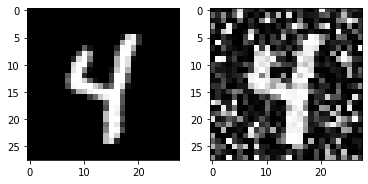

25  :  -0.08780401798084184 25
50  :  0.5470040540755435 25
75  :  0.4824471759808445 25
100  :  0.45842639370512117 25
125  :  0.5564028384919592 25
150  :  0.5499483641355476 25
175  :  0.5617739825541886 25
200  :  0.5592031774500885 25
225  :  0.5651971917121219 25
250  :  0.5655326230060558 25
275  :  0.5696049016375604 25
300  :  0.5710334887048971 25
325  :  0.5734919128671295 25
350  :  0.5735092872864934 25
375  :  0.5760446310492269 25
400  :  0.5785344615724951 25
425  :  0.5781383638513731 25
450  :  0.5800663226056704 25
475  :  0.5840675451668204 25
500  :  0.5850523727529287 25
525  :  0.5850523727529287 25
550  :  0.5855466470888857 25
575  :  0.5859982565928699 25
600  :  0.586066193405488 25
625  :  0.5861742272319272 25
650  :  0.5874008522728581 25
675  :  0.5876274181826806 25
700  :  0.5885795960743214 25
725  :  0.5889801783083131 25
750  :  0.5893886617440688 25
775  :  0.5893913434065047 25
800  :  0.5898487523681311 25
825  :  0.5900711930713545 25
850  :  0.5

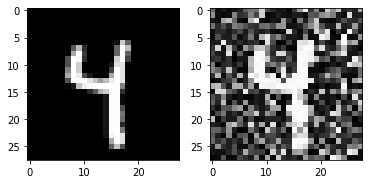

25  :  -0.14880763583279613 25
50  :  0.4018989870544645 25
75  :  0.17611534090062886 25
100  :  0.1825206133215082 25
125  :  0.2308120780978589 25
150  :  0.32596577215701344 25
175  :  0.4359299089640189 25
200  :  0.45710349882406087 25
225  :  0.48327025380878813 25
250  :  0.5101902650517891 25
275  :  0.5470040766957298 25
300  :  0.5470040766957298 25
325  :  0.5470040766957298 25
350  :  0.5778206121383183 25
375  :  0.5778206121383183 25
400  :  0.5778206121383183 25
425  :  0.5778206121383183 25
450  :  0.5811201233444636 25
475  :  0.5875308283803654 25
500  :  0.5920248401168605 25
525  :  0.5920489541953049 25
550  :  0.5920540173985563 25
575  :  0.5975551057423402 25
600  :  0.5983287106825631 25
625  :  0.5984000798717053 25
650  :  0.5996192418134751 25
675  :  0.5998934845153985 25
700  :  0.601449897133525 25
725  :  0.6028545182351732 25
750  :  0.6050698718900467 25
775  :  0.6052893888836715 25
800  :  0.6052893888836715 25
825  :  0.6061702128064625 25
850  :  

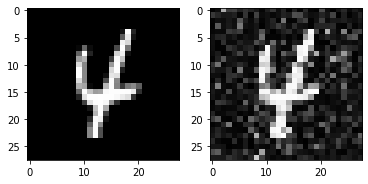

25  :  -0.2832597854834556 25
50  :  -0.21465544542805348 25
75  :  -0.2605168433204258 25
100  :  -0.18418207481696242 25
125  :  -0.014777750753817862 25
150  :  0.17439574469168712 25
175  :  0.4627558083214485 25
200  :  0.5546929006616221 25
225  :  0.555059009123455 25
250  :  0.5575988263018357 25
275  :  0.5673997386532466 25
300  :  0.5638387133954044 25
325  :  0.5638387133954044 25
350  :  0.5680103817675494 25
375  :  0.5660580045842245 25
400  :  0.5679142815178261 25
425  :  0.5718074290237352 25
450  :  0.5698818851436064 25
475  :  0.5698818851436064 25
500  :  0.5736755913966793 25
525  :  0.5743315100288945 25
550  :  0.5746585830913655 25
575  :  0.5751223879758676 25
600  :  0.5761207769783476 25
625  :  0.5769379698229883 25
650  :  0.5790937199415276 25
675  :  0.5794786567007121 25
700  :  0.5799949461915805 25
725  :  0.5820407083669227 25
750  :  0.5821751149396484 25
775  :  0.5843161931565024 25
800  :  0.5843161931565024 25
825  :  0.5843161931565024 25
850 

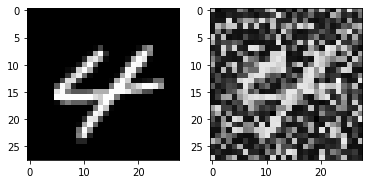

25  :  -0.3154106539277697 25
50  :  0.037136242411909895 25
75  :  -0.3154106539277697 25
100  :  -0.3154106539277697 25
125  :  -0.3154106539277697 25
150  :  -0.3154106539277697 25
175  :  -0.3154106539277697 25
200  :  -0.3154106539277697 25
225  :  -0.3154106539277697 25
250  :  -0.3154106539277697 25
275  :  -0.3154106539277697 25
300  :  -0.3154106539277697 25
325  :  -0.3154106539277697 25
350  :  -0.3154106539277697 25
375  :  -0.3154106539277697 25
400  :  -0.3154106539277697 25
425  :  -0.3154106539277697 25
450  :  -0.3154106539277697 25
475  :  -0.3154106539277697 25
500  :  -0.3154106539277697 25
525  :  -0.3154106539277697 25
550  :  -0.3154106539277697 25
575  :  -0.3154106539277697 25
600  :  -0.3154106539277697 25
625  :  -0.3154106539277697 25
650  :  -0.3154106539277697 25
675  :  -0.3154106539277697 25
700  :  -0.3154106539277697 25
725  :  -0.3154106539277697 25
750  :  -0.3154106539277697 25
775  :  -0.3154106539277697 25
800  :  -0.3154106539277697 25
825  :  -0

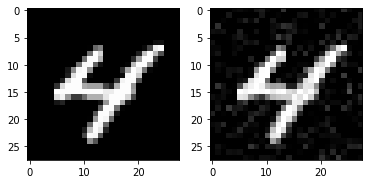

25  :  -0.19737006115970138 25
50  :  0.33352332798206136 25
75  :  0.4404111150517544 25
100  :  0.539913856461292 25
125  :  0.5681274991148911 25
150  :  0.5696945972595411 25
175  :  0.5817260181245664 25
200  :  0.576355317247691 25
225  :  0.5764832350677818 25
250  :  0.5840013545151616 25
275  :  0.5856993385902144 25
300  :  0.5856993385902144 25
325  :  0.5856993385902144 25
350  :  0.5856993385902144 25
375  :  0.5871771324860439 25
400  :  0.5871771324860439 25
425  :  0.5873585803123068 25
450  :  0.5883964518461937 25
475  :  0.5897105956378673 25
500  :  0.5911627673869989 25
525  :  0.5911628362996523 25
550  :  0.5920527948614492 25
575  :  0.5924164851752443 25
600  :  0.5924164851752443 25
625  :  0.5935031919398812 25
650  :  0.5941217692971501 25
675  :  0.5947729406519748 25
700  :  0.5947243354107016 25
725  :  0.5957961793980968 25
750  :  0.5959135692914734 25
775  :  0.596569953376981 25
800  :  0.5972503602356691 25
825  :  0.5972555854270464 25
850  :  0.598

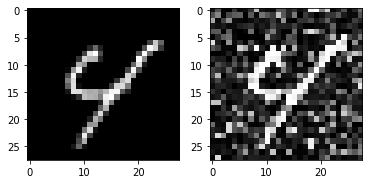

25  :  -0.20522587122574343 25
50  :  0.49410221132668564 25
75  :  -0.1620646510408313 25
100  :  0.2943125576010581 25
125  :  0.22204620372390055 25
150  :  0.32779676760225157 25
175  :  0.4868439343784361 25
200  :  0.5496570971321897 25
225  :  0.5666047225183766 25
250  :  0.569796224950282 25
275  :  0.5724773645489568 25
300  :  0.579519348317605 25
325  :  0.5800610482615884 25
350  :  0.5810570947394359 25
375  :  0.5808470989852037 25
400  :  0.5836745074378468 25
425  :  0.5849270504873592 25
450  :  0.5865592117871697 25
475  :  0.5912307912204744 25
500  :  0.5913069758797649 25
525  :  0.5929498494217091 25
550  :  0.5927042880091224 25
575  :  0.593153147860394 25
600  :  0.5937038885652202 25
625  :  0.5969006806046422 25
650  :  0.5971222073875215 25
675  :  0.5981852536107098 25
700  :  0.5991983708001112 25
725  :  0.5996606256425465 25
750  :  0.5998270688528099 25
775  :  0.6008724489001405 25
800  :  0.6008724489001405 25
825  :  0.6010497882986808 25
850  :  0.

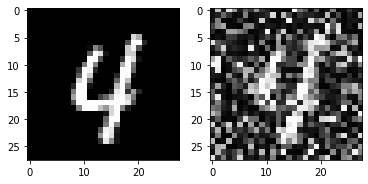

25  :  -0.15813753122111002 25
50  :  0.1563473748740123 25
75  :  0.09245041307596363 25
100  :  0.3828959773792481 25
125  :  0.48790820765726134 25
150  :  0.5372778188181189 25
175  :  0.5048830485982718 25
200  :  0.5600377158613414 25
225  :  0.5838456885829233 25
250  :  0.580607483950371 25
275  :  0.5867644565504994 25
300  :  0.5981927705482485 25
325  :  0.6012575177255964 25
350  :  0.599753681160448 25
375  :  0.6027077398046039 25
400  :  0.6044018279666612 25
425  :  0.6070035291302447 25
450  :  0.607162384856757 25
475  :  0.6093027618173933 25
500  :  0.611661291303959 25
525  :  0.6102528936768201 25
550  :  0.6116621500770869 25
575  :  0.6115539325419513 25
600  :  0.612117900135504 25
625  :  0.6131732955822671 25
650  :  0.6133191186751122 25
675  :  0.6135785649639455 25
700  :  0.6135785649639455 25
725  :  0.6143656381799143 25
750  :  0.6146912064328252 25
775  :  0.6155894194605079 25
800  :  0.6156437554913834 25
825  :  0.6158845103658368 25
850  :  0.6169

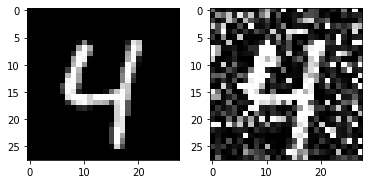

25  :  -0.050894043298694625 25
50  :  0.5533146527745975 25
75  :  0.5295866308913864 25
100  :  0.37560794961840394 25
125  :  0.5231843914872265 25
150  :  0.5528713930728244 25
175  :  0.5381624806447896 25
200  :  0.5175432256348081 25
225  :  0.5275243597955988 25
250  :  0.5376420356968268 25
275  :  0.5448051664269647 25
300  :  0.5585881899053771 25
325  :  0.5585881899053771 25
350  :  0.5598297727163121 25
375  :  0.5701301623130175 25
400  :  0.5701301623130175 25
425  :  0.5701301623130175 25
450  :  0.5725195658255796 25
475  :  0.5758573923746134 25
500  :  0.5802450025823584 25
525  :  0.5800107630757122 25
550  :  0.5878962375138342 25
575  :  0.5871448872418867 25
600  :  0.5882512791703031 25
625  :  0.5892854800548111 25
650  :  0.5907071081068835 25
675  :  0.5907071081068835 25
700  :  0.5907071081068835 25
725  :  0.5913260797708342 25
750  :  0.591983504619308 25
775  :  0.5927619872177331 25
800  :  0.5935071738414209 25
825  :  0.5936050711483917 25
850  :  0.

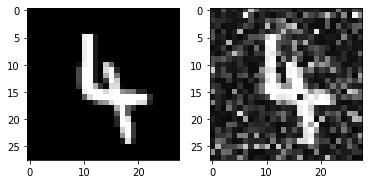

25  :  -0.0883918956908058 25
50  :  0.19433765702732067 25
75  :  0.26716259614251375 25
100  :  0.4757515357330572 25
125  :  0.5268226480009546 25
150  :  0.5270647649777696 25
175  :  0.5380962242484078 25
200  :  0.5380962242484078 25
225  :  0.5485610964204365 25
250  :  0.5488225860810116 25
275  :  0.5544172912520628 25
300  :  0.5592841476176399 25
325  :  0.5645296098157725 25
350  :  0.5650953397041882 25
375  :  0.5690082758465176 25
400  :  0.5722089926411871 25
425  :  0.5745226435087349 25
450  :  0.5774014801232711 25
475  :  0.5802677589273513 25
500  :  0.5832718110200449 25
525  :  0.5840320114880957 25
550  :  0.5847879622684692 25
575  :  0.5850041697422477 25
600  :  0.5851193497588572 25
625  :  0.5850041697422477 25
650  :  0.5869829924917788 25
675  :  0.5870327444833321 25
700  :  0.5868563920026459 25
725  :  0.5895753866119812 25
750  :  0.5907384681577729 25
775  :  0.5914884014449473 25
800  :  0.5933898293251452 25
825  :  0.5960454930794866 25
850  :  0.

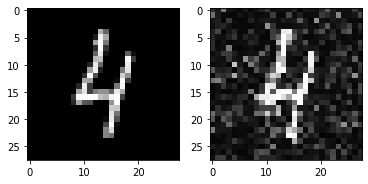

25  :  -0.3223150628501058 25
50  :  -0.31603670618064716 25
75  :  -0.31603670618064716 25
100  :  -0.302126846065325 25
125  :  -0.28398644695100106 25
150  :  -0.26125752816059405 25
175  :  -0.18477470078592884 25
200  :  -0.0623829678018956 25
225  :  0.0683712446264688 25
250  :  0.12313473521834496 25
275  :  0.16403955934068334 25
300  :  0.2587467055769395 25
325  :  0.2828055912905468 25
350  :  0.3447306154846021 25
375  :  0.3492764142033018 25
400  :  0.4266770906379667 25
425  :  0.46712577185157295 25
450  :  0.4894916065287132 25
475  :  0.4884080107116835 25
500  :  0.4994032449541288 25
525  :  0.5216098033215169 25
550  :  0.5241966743052773 25
575  :  0.5274688623001278 25
600  :  0.5354951626995952 25
625  :  0.5392511009847598 25
650  :  0.5414814724469356 25
675  :  0.5418971689973799 25
700  :  0.5457885848970816 25
725  :  0.5510636211948106 25
750  :  0.5512699755366672 25
775  :  0.5530242647098664 25
800  :  0.553558154046077 25
825  :  0.5553391020005262 25

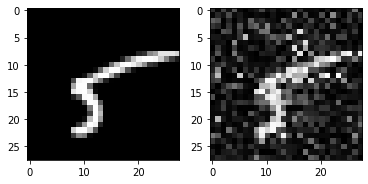

25  :  -0.2500013440556037 25
50  :  -0.2038639419210304 25
75  :  -0.22813782184134831 25
100  :  -0.18869356473067536 25
125  :  -0.16347674345106827 25
150  :  -0.1119014711000394 25
175  :  -0.0338525142604162 25
200  :  0.006043692772066692 25
225  :  -0.013540969850745488 25
250  :  0.0819963957853012 25
275  :  0.07255042545176531 25
300  :  0.14980662875537892 25
325  :  0.1312196316487762 25
350  :  0.2608906337396942 25
375  :  0.2809040373006954 25
400  :  0.3480379093248547 25
425  :  0.3402959461066586 25
450  :  0.3321339594109718 25
475  :  0.39356956382161845 25
500  :  0.4426598735896734 25
525  :  0.4361036476185018 25
550  :  0.43929856049688104 25
575  :  0.42938776899144376 25
600  :  0.44293126057219867 25
625  :  0.44832819148144804 25
650  :  0.46665342761236184 25
675  :  0.48579902657914525 25
700  :  0.48484282973490933 25
725  :  0.4981238832751437 25
750  :  0.512427635434583 25
775  :  0.5294877872174572 25
800  :  0.5393788910135576 25
825  :  0.540081637

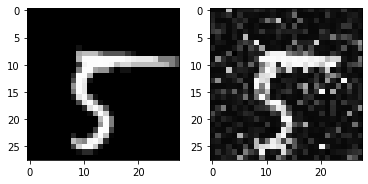

25  :  -0.2909421633833076 25
50  :  -0.28809496634753307 25
75  :  -0.28863575656798157 25
100  :  -0.2883915472638431 25
125  :  -0.2861709514250237 25
150  :  -0.2779207057581008 25
175  :  -0.2654787424082313 25
200  :  -0.25138457741909337 25
225  :  -0.23340369528158655 25
250  :  -0.17100244784991292 25
275  :  -0.1630231267104593 25
300  :  -0.1058588609323887 25
325  :  -0.07644057945471122 25
350  :  -0.007534546664119179 25
375  :  0.051829677303283944 25
400  :  0.07133588487359108 25
425  :  0.10310479309560415 25
450  :  0.20061427036276097 25
475  :  0.19949563849874505 25
500  :  0.19949563849874505 25
525  :  0.21855355001628465 25
550  :  0.2661704547785166 25
575  :  0.2634547857910737 25
600  :  0.29754805105141385 25
625  :  0.32635150266112367 25
650  :  0.34027833645805994 25
675  :  0.3525348802624181 25
700  :  0.36705128106539686 25
725  :  0.3812412810456606 25
750  :  0.39043476398713195 25
775  :  0.4029145920188907 25
800  :  0.42673346017982794 25
825  : 

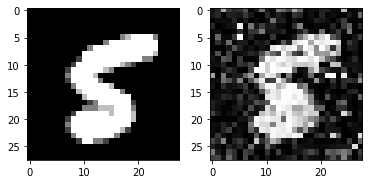

25  :  -0.3013496961536415 25
50  :  -0.3013496961536415 25
75  :  -0.3013496961536415 25
100  :  -0.3013496961536415 25
125  :  -0.3013496961536415 25
150  :  -0.3013496961536415 25
175  :  -0.3013496961536415 25
200  :  -0.30108569467439406 25
225  :  -0.30108569467439406 25
250  :  -0.30108569467439406 25
275  :  -0.30080945127351866 25
300  :  -0.3007628961144121 25
325  :  -0.30052327371598864 25
350  :  -0.30052327371598864 25
375  :  -0.3004384437425676 25
400  :  -0.2999792608508831 25
425  :  -0.2995976239557626 25
450  :  -0.29937308833711546 25
475  :  -0.2992313940906842 25
500  :  -0.29795642777593034 25
525  :  -0.29795642777593034 25
550  :  -0.2966403727348004 25
575  :  -0.2963888196767429 25
600  :  -0.2963888792812639 25
625  :  -0.29584113547843965 25
650  :  -0.29584113547843965 25
675  :  -0.29584113547843965 25
700  :  -0.29584113547843965 25
725  :  -0.29498364644589126 25
750  :  -0.2940923673300769 25
775  :  -0.2940923673300769 25
800  :  -0.29363638038911477

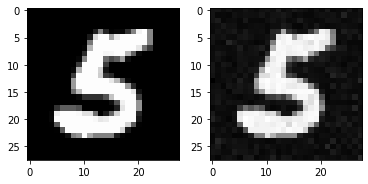

25  :  -0.29659695245852935 25
50  :  -0.29659695245852935 25
75  :  -0.29659695245852935 25
100  :  -0.29473170617106625 25
125  :  -0.29248853184256896 25
150  :  -0.29150453251101294 25
175  :  -0.28607847331828806 25
200  :  -0.27245577215475597 25
225  :  -0.2376053353517158 25
250  :  -0.21028373047368962 25
275  :  -0.1721976993211018 25
300  :  -0.14802063920063976 25
325  :  -0.055630446338414075 25
350  :  -0.01528759093646126 25
375  :  -0.015452597054348371 25
400  :  0.057592746364191844 25
425  :  0.09506053993905383 25
450  :  0.11009205594538315 25
475  :  0.19640035769119873 25
500  :  0.2061994965865568 25
525  :  0.24221986828425252 25
550  :  0.25604655840298046 25
575  :  0.2635278220374506 25
600  :  0.2709512697244263 25
625  :  0.2955367890466396 25
650  :  0.30819477553662933 25
675  :  0.3142051771469718 25
700  :  0.32833781966581876 25
725  :  0.3345052641176658 25
750  :  0.3306755173128466 25
775  :  0.3342644381947889 25
800  :  0.3400892631348137 25
825 

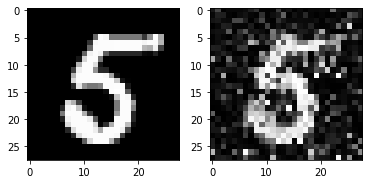

25  :  -0.1735804643551211 25
50  :  -0.1350400393406155 25
75  :  -0.10359044229208189 25
100  :  -0.02863742025011151 25
125  :  0.006499432366934538 25
150  :  0.09266589185695806 25
175  :  0.2386431745755062 25
200  :  0.42780967298304773 25
225  :  0.4856689101519942 25
250  :  0.5366915072104532 25
275  :  0.5384273504341919 25
300  :  0.5441425957224975 25
325  :  0.5665191992815798 25
350  :  0.5606330794168322 25
375  :  0.5606330794168322 25
400  :  0.5815564167629214 25
425  :  0.5815116379974884 25
450  :  0.5815116379974884 25
475  :  0.5839871811440627 25
500  :  0.5844739563209514 25
525  :  0.5923274885593468 25
550  :  0.5941938335689648 25
575  :  0.5961544189421197 25
600  :  0.5973887949370271 25
625  :  0.5973887949370271 25
650  :  0.5986455957073443 25
675  :  0.5994885951420613 25
700  :  0.6004974204098887 25
725  :  0.600883968180272 25
750  :  0.6013732802567834 25
775  :  0.6037073834083636 25
800  :  0.6039842155149442 25
825  :  0.6053926937478629 25
850 

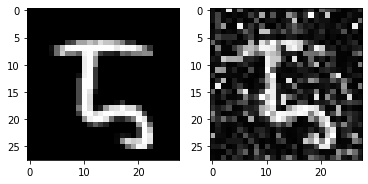

25  :  0.6172269946935449 25
50  :  0.6240233717878458 25
75  :  0.6240233717878458 25
100  :  0.6240233717878458 25
125  :  0.6267862692645254 25
150  :  0.6291292308666521 25
175  :  0.6312148935606791 25
200  :  0.6315628101432829 25
225  :  0.6356437650874022 25
250  :  0.6356437650874022 25
275  :  0.6367082074551998 25
300  :  0.6383844479700591 25
325  :  0.6387092508887845 25
350  :  0.6386923284332668 25
375  :  0.6405013551377097 25
400  :  0.6407876675877759 25
425  :  0.6407876675877759 25
450  :  0.6427979229360697 25
475  :  0.6427979229360697 25
500  :  0.6427979229360697 25
525  :  0.6429001676153318 25
550  :  0.6429873114841025 25
575  :  0.6434518039166522 25
600  :  0.6435140843362 25
625  :  0.6438868857134155 25
650  :  0.6441884744147326 25
675  :  0.6444305651455225 25
700  :  0.6445097388598957 25
725  :  0.6447680206639063 25
750  :  0.6447698982102209 25
775  :  0.6447698982102209 25
800  :  0.6448433904137807 25
Time:  63.32044792175293  seconds
Predicted cl

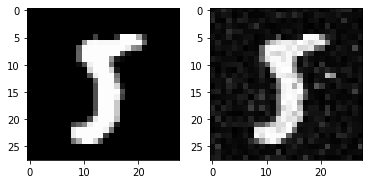

25  :  0.42803986519210524 25
50  :  0.42803986519210524 25
75  :  0.4552149846346508 25
100  :  0.47166193341749496 25
125  :  0.4776327650293286 25
150  :  0.5059220709695809 25
175  :  0.5456409186607079 25
200  :  0.5589283483773532 25
225  :  0.5670468760402573 25
250  :  0.5810581490965296 25
275  :  0.5829465878585319 25
300  :  0.5877741355700977 25
325  :  0.5887754587556195 25
350  :  0.5943190166719396 25
375  :  0.5943190166719396 25
400  :  0.5970071087069123 25
425  :  0.5970478425383329 25
450  :  0.5970478425383329 25
475  :  0.5971248889122155 25
500  :  0.5971828798034027 25
525  :  0.5990500148516893 25
550  :  0.5993929100172398 25
575  :  0.6000684451751191 25
600  :  0.6003128256381626 25
625  :  0.6010587894949838 25
650  :  0.6013679593880844 25
675  :  0.6024200143165486 25
700  :  0.6024156610579592 25
725  :  0.6029189747775477 25
750  :  0.6029074565142603 25
775  :  0.602945836746503 25
800  :  0.6038926978415562 25
825  :  0.603890762860479 25
850  :  0.60

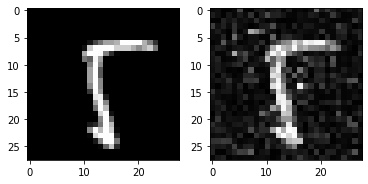

25  :  -0.08025083953405379 25
50  :  -0.06235855965983686 25
75  :  -0.04022708837187253 25
100  :  0.1608434143914164 25
125  :  0.161420064126161 25
150  :  0.161420064126161 25
175  :  0.24683382669157103 25
200  :  0.30508093088106386 25
225  :  0.32242498207014214 25
250  :  0.4473919315771219 25
275  :  0.5475649636515363 25
300  :  0.5801642556825694 25
325  :  0.5844666480742757 25
350  :  0.5844666480742757 25
375  :  0.5915913974612844 25
400  :  0.5928174683265586 25
425  :  0.5948681303479024 25
450  :  0.5981124273892912 25
475  :  0.596965615812077 25
500  :  0.596965615812077 25
525  :  0.596965615812077 25
550  :  0.600090204421868 25
575  :  0.6008695970348966 25
600  :  0.6020059775471303 25
625  :  0.6104672334876061 25
650  :  0.6124739820438836 25
675  :  0.612634073387084 25
700  :  0.6124849107845954 25
725  :  0.6124849107845954 25
750  :  0.6124849107845954 25
775  :  0.6164680110092949 25
800  :  0.6198975962837341 25
825  :  0.6198975962837341 25
850  :  0.6

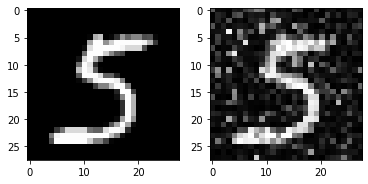

25  :  0.09155574130083244 25
50  :  0.1027118730405357 25
75  :  0.1263000576291141 25
100  :  0.17432066644277946 25
125  :  0.22742086423498575 25
150  :  0.29669487455291144 25
175  :  0.3816003092943522 25
200  :  0.4198157727551577 25
225  :  0.48737682013799266 25
250  :  0.5063298035418864 25
275  :  0.5391282674604839 25
300  :  0.5493798518672606 25
325  :  0.5559301972667852 25
350  :  0.5667778008300902 25
375  :  0.5775425700716417 25
400  :  0.5848367954663873 25
425  :  0.5848367954663873 25
450  :  0.5848367954663873 25
475  :  0.5931220868412571 25
500  :  0.6019896910433057 25
525  :  0.6021304826497128 25
550  :  0.6031962924045291 25
575  :  0.6056107313386748 25
600  :  0.6077029653248107 25
625  :  0.6095347803185813 25
650  :  0.6103533733020283 25
675  :  0.6154709971134288 25
700  :  0.620770206293176 25
725  :  0.6208698307883924 25
750  :  0.6208698307883924 25
775  :  0.6210602306760955 25
800  :  0.6208698307883924 25
825  :  0.6218819716601633 25
850  :  0

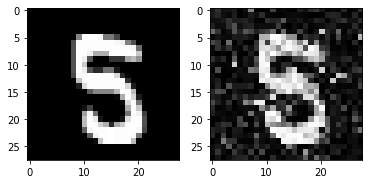

25  :  0.3613452398449639 25
50  :  0.42884563971610523 25
75  :  0.436914524794634 25
100  :  0.43565834274858806 25
125  :  0.46121440806279346 25
150  :  0.5121933471550217 25
175  :  0.506681986014917 25
200  :  0.5432193896607768 25
225  :  0.5686776198682744 25
250  :  0.5803022346224205 25
275  :  0.5822738766192425 25
300  :  0.585210642954572 25
325  :  0.5868700137089498 25
350  :  0.5868700137089498 25
375  :  0.58741168539363 25
400  :  0.5875445468964517 25
425  :  0.5939109751535487 25
450  :  0.5955318121831715 25
475  :  0.5960926267474198 25
500  :  0.5968067768569716 25
525  :  0.5973079624783435 25
550  :  0.5973236569941989 25
575  :  0.5973236569941989 25
600  :  0.5973236569941989 25
625  :  0.5989878952136629 25
650  :  0.5993010777350108 25
675  :  0.5993344824987417 25
700  :  0.5993411454559595 25
725  :  0.5996706202027676 25
750  :  0.599807776584147 25
775  :  0.599807776584147 25
800  :  0.5998353469633534 25
825  :  0.6007267118302685 25
850  :  0.6007235

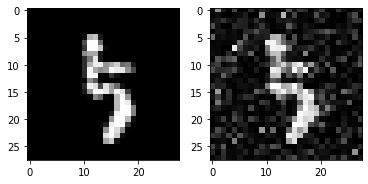

25  :  -0.2264760148168253 25
50  :  -0.22253596484172167 25
75  :  -0.2264760148168253 25
100  :  -0.22625027926954816 25
125  :  -0.20518813155009447 25
150  :  -0.20447287953209115 25
175  :  -0.14892548999383504 25
200  :  -0.1419463064559478 25
225  :  -0.07009339661901492 25
250  :  -0.04224445172801487 25
275  :  0.05270301432193167 25
300  :  0.06309616651391821 25
325  :  0.07712649181270147 25
350  :  0.10545021242907049 25
375  :  0.13763864920387694 25
400  :  0.15253141771523304 25
425  :  0.18621598224586242 25
450  :  0.1932280637908997 25
475  :  0.2086858129134021 25
500  :  0.22219383597110726 25
525  :  0.2698733629813885 25
550  :  0.2810326102273615 25
575  :  0.3046376869884892 25
600  :  0.3117135416022724 25
625  :  0.31459392765748845 25
650  :  0.3214844360461699 25
675  :  0.32735007132066635 25
700  :  0.34986616479218996 25
725  :  0.3616680727051226 25
750  :  0.3735846180687671 25
775  :  0.37434392022201707 25
800  :  0.3834830773611129 25
825  :  0.3843

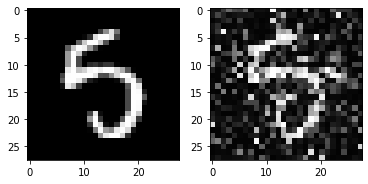

25  :  0.6221850933947748 25
50  :  0.6221851067919573 25
75  :  0.6372437668350917 25
100  :  0.6455892196877335 25
125  :  0.6511289938994936 25
150  :  0.6617387149404071 25
175  :  0.6648941493041326 25
200  :  0.6684657689844553 25
225  :  0.6681002780110229 25
250  :  0.6681002780110229 25
275  :  0.6780281835286252 25
300  :  0.6780121100870566 25
325  :  0.6794341979249678 25
350  :  0.6791204396334929 25
375  :  0.6827905321833295 25
400  :  0.6827905321833295 25
425  :  0.6827905321833295 25
450  :  0.6827905321833295 25
475  :  0.6830922780587776 25
500  :  0.6844382347310991 25
525  :  0.6843237432336577 25
550  :  0.6862143187232286 25
575  :  0.6862143187232286 25
600  :  0.6884684525061311 25
625  :  0.6890418872766453 25
650  :  0.6890342419497801 25
675  :  0.6903521533647157 25
700  :  0.6904839050057024 25
725  :  0.6905038242010954 25
750  :  0.6919043640510955 25
775  :  0.6920685860532985 25
800  :  0.6920685860532985 25
825  :  0.6920685860532985 25
850  :  0.692

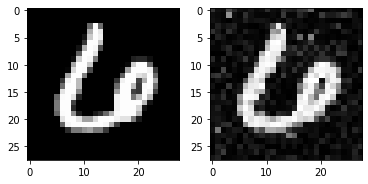

25  :  0.34447318660183535 25
50  :  0.5576198457184841 25
75  :  0.46306430858954634 25
100  :  0.5386082995721239 25
125  :  0.5473644065638553 25
150  :  0.5679862176614335 25
175  :  0.5641812701702402 25
200  :  0.5506075886981805 25
225  :  0.5558466959241662 25
250  :  0.5630080649237444 25
275  :  0.5551779487126877 25
300  :  0.557201224031926 25
325  :  0.5584833418067667 25
350  :  0.5791205709761656 25
375  :  0.5813461129505012 25
400  :  0.5769828051237816 25
425  :  0.583726439166054 25
450  :  0.5978569784745467 25
475  :  0.5996687455152664 25
500  :  0.6094667447290978 25
525  :  0.6089322831811051 25
550  :  0.6089322831811051 25
575  :  0.6118642214224382 25
600  :  0.6139759804488073 25
625  :  0.6175524126654633 25
650  :  0.6177044093522795 25
675  :  0.6203044138367072 25
700  :  0.62055154060608 25
725  :  0.6212243114304304 25
750  :  0.6234496378905068 25
775  :  0.6231650532616838 25
800  :  0.6231650532616838 25
825  :  0.6240693868643064 25
850  :  0.62466

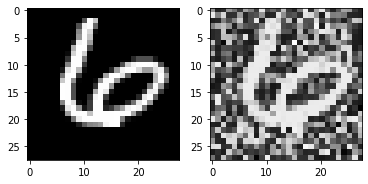

25  :  0.2148291069654935 25
50  :  0.5719911083927457 25
75  :  0.21998222417639157 25
100  :  0.5257645690168884 25
125  :  0.5820739500526897 25
150  :  0.5826076613084514 25
175  :  0.6044111083899169 25
200  :  0.6071403110980093 25
225  :  0.6068658298136211 25
250  :  0.6083814784579251 25
275  :  0.6120723760681532 25
300  :  0.6175473188701405 25
325  :  0.6181139703680816 25
350  :  0.6189876348376502 25
375  :  0.6192969644920205 25
400  :  0.6192969644920205 25
425  :  0.6193505391609643 25
450  :  0.621486141522017 25
475  :  0.621486141522017 25
500  :  0.6223799988315255 25
525  :  0.6229633591421705 25
550  :  0.6228907114260926 25
575  :  0.6235666449923496 25
600  :  0.6234585163376781 25
625  :  0.6243398406092243 25
650  :  0.6247716887928607 25
675  :  0.6247781481339063 25
700  :  0.6247781481339063 25
725  :  0.6259392194839271 25
750  :  0.6259260659061106 25
775  :  0.6260707271726319 25
800  :  0.6263131951199556 25
825  :  0.6270674148495952 25
850  :  0.6270

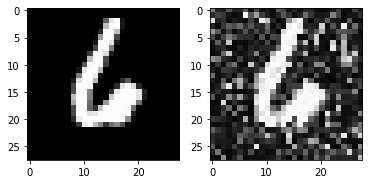

25  :  0.431445822160369 25
50  :  0.588848672796075 25
75  :  0.579878727648274 25
100  :  0.5789818994961416 25
125  :  0.576916052215255 25
150  :  0.5739553416201842 25
175  :  0.5792494291947361 25
200  :  0.5767642863487923 25
225  :  0.5840729574612823 25
250  :  0.5824659060132915 25
275  :  0.5859402172599145 25
300  :  0.5871496534651859 25
325  :  0.5962864308769829 25
350  :  0.5994634227257161 25
375  :  0.5997499604905854 25
400  :  0.6034810509809768 25
425  :  0.6023402841784611 25
450  :  0.6025247885768902 25
475  :  0.6048322054172952 25
500  :  0.6060315257317007 25
525  :  0.6058336812639983 25
550  :  0.6061581457057533 25
575  :  0.6077559224293577 25
600  :  0.6120566203879748 25
625  :  0.6112857435848902 25
650  :  0.6114362768677754 25
675  :  0.6113255612836364 25
700  :  0.6131524690208143 25
725  :  0.613028727213093 25
750  :  0.613028727213093 25
775  :  0.6137538129296534 25
800  :  0.6137538129296534 25
825  :  0.6153450778837986 25
Time:  64.820509433

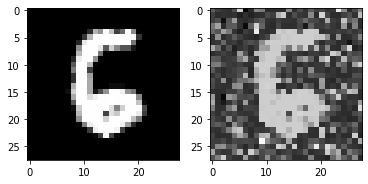

25  :  0.5409514948612486 25
50  :  0.5931503225030056 25
75  :  0.4983797073433671 25
100  :  0.5564107932393043 25
125  :  0.5710757703361657 25
150  :  0.5717248852011911 25
175  :  0.5794350089347988 25
200  :  0.5945338791517718 25
225  :  0.596394637078426 25
250  :  0.6053427264512943 25
275  :  0.6070105708531859 25
300  :  0.6025351811420128 25
325  :  0.6063141447181258 25
350  :  0.6063141447181258 25
375  :  0.6067863451512535 25
400  :  0.6106437142543526 25
425  :  0.6119276648249304 25
450  :  0.6124755522547234 25
475  :  0.6124755522547234 25
500  :  0.6124755522547234 25
525  :  0.6149462908434568 25
550  :  0.6149462908434568 25
575  :  0.6149462908434568 25
600  :  0.6149462908434568 25
625  :  0.6149462908434568 25
650  :  0.6157954669316332 25
675  :  0.6160051181356224 25
700  :  0.6160051181356224 25
725  :  0.6160051181356224 25
750  :  0.6160051181356224 25
775  :  0.6160517132628677 25
800  :  0.6165920864713106 25
825  :  0.6171004971828831 25
850  :  0.6171

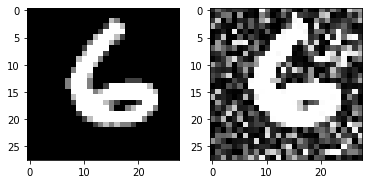

25  :  0.39879371172280453 25
50  :  0.5884971858730319 25
75  :  0.5598365560839453 25
100  :  0.5768296307473268 25
125  :  0.5664973435550853 25
150  :  0.580544937911008 25
175  :  0.5770236919444522 25
200  :  0.589193216770236 25
225  :  0.5876001643092246 25
250  :  0.6076411130657086 25
275  :  0.6066885770180741 25
300  :  0.6066885770180741 25
325  :  0.6066885770180741 25
350  :  0.6123191790996644 25
375  :  0.6145117723801816 25
400  :  0.6152964606927975 25
425  :  0.6185250056326579 25
450  :  0.6202572540382012 25
475  :  0.6202572540382012 25
500  :  0.6202572540382012 25
525  :  0.6202572540382012 25
550  :  0.6208769771423645 25
575  :  0.6216554078789471 25
600  :  0.6216554078789471 25
625  :  0.6231446915046506 25
650  :  0.6230715201227834 25
675  :  0.6245691460030138 25
700  :  0.6234284476884783 25
725  :  0.6256778410522315 25
750  :  0.6259388483651821 25
775  :  0.6265254278170318 25
800  :  0.6263905011602975 25
825  :  0.6272979791376223 25
850  :  0.6281

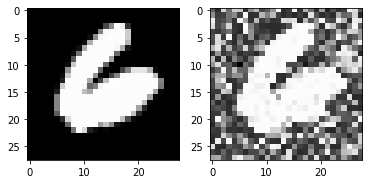

25  :  0.6413709890312492 25
50  :  0.6448618141593091 25
75  :  0.6340182991690697 25
100  :  0.6283677702700602 25
125  :  0.6214627430379562 25
150  :  0.6179115814882227 25
175  :  0.6343284286089657 25
200  :  0.6252399335499197 25
225  :  0.6333170461391024 25
250  :  0.6333170461391024 25
275  :  0.634390243883981 25
300  :  0.6399171928416157 25
325  :  0.640451986845117 25
350  :  0.6441201752826633 25
375  :  0.6455859926520895 25
400  :  0.6455859926520895 25
425  :  0.6462399691175919 25
450  :  0.6481428673281291 25
475  :  0.6488664054961323 25
500  :  0.6490361668345143 25
525  :  0.6504204565252399 25
550  :  0.6504169894780705 25
575  :  0.6510129920467436 25
600  :  0.6521164621396449 25
625  :  0.6524393341627656 25
650  :  0.6524059435847406 25
675  :  0.6525553318201378 25
700  :  0.652560998083355 25
725  :  0.6530447939383053 25
750  :  0.6531980068333747 25
775  :  0.6533467508939101 25
800  :  0.6533467508939101 25
825  :  0.6534421270040649 25
850  :  0.653458

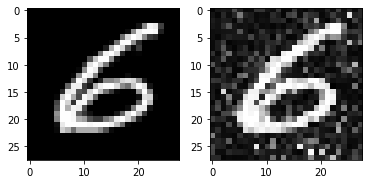

25  :  0.5911149003086276 25
50  :  0.6064176449408902 25
75  :  0.5972489528138765 25
100  :  0.5991698741026936 25
125  :  0.5927557020631441 25
150  :  0.5954708378405851 25
175  :  0.6171399983665434 25
200  :  0.6109113497126352 25
225  :  0.6153382872274571 25
250  :  0.6107952022451967 25
275  :  0.6121324984805113 25
300  :  0.6219306002090167 25
325  :  0.6203155196190479 25
350  :  0.6193840493756971 25
375  :  0.6193840493756971 25
400  :  0.6193840493756971 25
425  :  0.6212300852400656 25
450  :  0.6231272540455508 25
475  :  0.6226684728903791 25
500  :  0.6259503657714917 25
525  :  0.6269037972714181 25
550  :  0.6274152158458695 25
575  :  0.6287977004047006 25
600  :  0.6297352082648654 25
625  :  0.6311071350832875 25
650  :  0.6307388515666923 25
675  :  0.6315298978117366 25
700  :  0.6314392302863213 25
725  :  0.6317355956148836 25
750  :  0.6321977577516068 25
775  :  0.6341530348012367 25
800  :  0.6341701308279044 25
825  :  0.6341701308279044 25
850  :  0.634

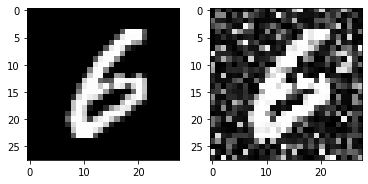

25  :  -0.2682282555408223 25
50  :  0.06377794800803759 25
75  :  0.06186277195835148 25
100  :  -0.3244986185268175 25
125  :  0.06906971986245117 25
150  :  -0.16662522258729637 25
175  :  -0.3244986185268175 25
200  :  -0.3244986185268175 25
225  :  -0.3244986185268175 25
250  :  -0.3244986185268175 25
275  :  -0.3244986185268175 25
300  :  -0.3244986185268175 25
325  :  -0.3244986185268175 25
350  :  -0.3244986185268175 25
375  :  -0.3244986185268175 25
400  :  -0.3244986185268175 25
425  :  -0.3244986185268175 25
450  :  -0.3244986185268175 25
475  :  -0.3244986185268175 25
500  :  -0.3244986185268175 25
525  :  -0.3244986185268175 25
550  :  -0.3244986185268175 25
575  :  -0.3244986185268175 25
600  :  -0.3244986185268175 25
625  :  -0.3244986185268175 25
650  :  -0.3244986185268175 25
675  :  -0.3244986185268175 25
700  :  -0.3244986185268175 25
725  :  -0.3244986185268175 25
750  :  -0.3244986185268175 25
775  :  -0.3244986185268175 25
800  :  -0.3244986185268175 25
825  :  -0

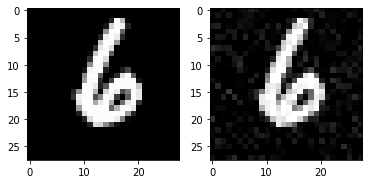

25  :  0.6183897169749472 25
50  :  0.6213710480857061 25
75  :  0.6123641532405634 25
100  :  0.6080065017916151 25
125  :  0.6041497643137422 25
150  :  0.6227749109480293 25
175  :  0.6236852063933245 25
200  :  0.6216480138468354 25
225  :  0.622555895195546 25
250  :  0.6241105839592249 25
275  :  0.6291103913893933 25
300  :  0.6291103913893933 25
325  :  0.6291103913893933 25
350  :  0.6324954950922244 25
375  :  0.6323023785105499 25
400  :  0.6325090423458649 25
425  :  0.634825456240384 25
450  :  0.6350547615124591 25
475  :  0.6359628812790976 25
500  :  0.6359627327596574 25
525  :  0.6359627327596574 25
550  :  0.6359627327596574 25
575  :  0.6359627327596574 25
600  :  0.6369371173993963 25
625  :  0.6373961282152825 25
650  :  0.6390584741320381 25
675  :  0.6393946878853308 25
700  :  0.6393771076673903 25
725  :  0.6396992632468355 25
750  :  0.6411663768753111 25
775  :  0.6412026561304409 25
800  :  0.6412026561304409 25
825  :  0.6412026561304409 25
850  :  0.64185

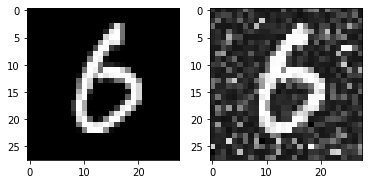

25  :  -0.12802774489304142 25
50  :  0.48874389876302476 25
75  :  0.3064735518223688 25
100  :  0.07747443387991243 25
125  :  0.3249685666018767 25
150  :  0.0017540070789821283 25
175  :  0.5202913073031288 25
200  :  0.5158095152070532 25
225  :  0.5721959838808793 25
250  :  0.5730069514714555 25
275  :  0.5687605849528626 25
300  :  0.5681470730153487 25
325  :  0.5697721660522221 25
350  :  0.5747764624915194 25
375  :  0.5794522429963275 25
400  :  0.5831916260935429 25
425  :  0.5824638443680018 25
450  :  0.5865999177167549 25
475  :  0.589287174865721 25
500  :  0.5887646954922006 25
525  :  0.5901710102305446 25
550  :  0.5907788852396362 25
575  :  0.5916736354432446 25
600  :  0.5936610190676141 25
625  :  0.5935858143370152 25
650  :  0.5950232319090945 25
675  :  0.5940283081068545 25
700  :  0.5949132949045569 25
725  :  0.5963774591163847 25
750  :  0.5973738927869551 25
775  :  0.598199476731133 25
800  :  0.5983247807495211 25
825  :  0.5996639325617613 25
850  :  

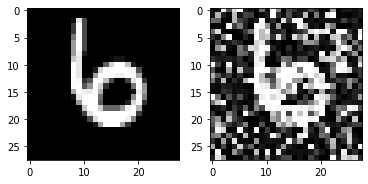

25  :  0.470703290717597 25
50  :  0.5910500856897772 25
75  :  0.5901648145658962 25
100  :  0.5706909803713902 25
125  :  0.5704823260614913 25
150  :  0.5741204521185428 25
175  :  0.5651057797212603 25
200  :  0.5816131570896654 25
225  :  0.5798316693290443 25
250  :  0.5822827121418783 25
275  :  0.5860361743753737 25
300  :  0.5890918412335011 25
325  :  0.590523784518606 25
350  :  0.5928693326887687 25
375  :  0.5978389657389085 25
400  :  0.5983128298475398 25
425  :  0.598393108335185 25
450  :  0.5983128298475398 25
475  :  0.5995498264122139 25
500  :  0.6001386739156211 25
525  :  0.6001931933781741 25
550  :  0.6016323581142117 25
575  :  0.6020307967419293 25
600  :  0.6030033489931957 25
625  :  0.6037856980540178 25
650  :  0.6049505484650608 25
675  :  0.6072813514718336 25
700  :  0.6073895938881266 25
725  :  0.6079122561471423 25
750  :  0.6082294835701416 25
775  :  0.6092724576174934 25
800  :  0.6096002385505137 25
825  :  0.6096002385505137 25
850  :  0.609809

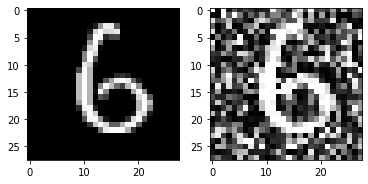

25  :  0.5362492092860356 25
50  :  0.5810437025288049 25
75  :  0.5611524623422899 25
100  :  0.5564786884400084 25
125  :  0.5745963036373012 25
150  :  0.5560730686908949 25
175  :  0.5152957821913261 25
200  :  0.55010983263329 25
225  :  0.5764674665760822 25
250  :  0.5729444727079278 25
275  :  0.5944634471759741 25
300  :  0.596143319055406 25
325  :  0.5915913007588125 25
350  :  0.5995590302208264 25
375  :  0.5964139062436039 25
400  :  0.6024578543363613 25
425  :  0.6047320045553652 25
450  :  0.6047320045553652 25
475  :  0.6084616585917054 25
500  :  0.6095991953887399 25
525  :  0.6098185395520469 25
550  :  0.6112585686093481 25
575  :  0.6141793578957192 25
600  :  0.6140671444548804 25
625  :  0.6141364428639738 25
650  :  0.615461529088388 25
675  :  0.615644009489633 25
700  :  0.6156980168232599 25
725  :  0.615883093985567 25
750  :  0.616422563294705 25
775  :  0.6166340068502898 25
800  :  0.6175367238784746 25
825  :  0.6175635607165146 25
850  :  0.6177571065

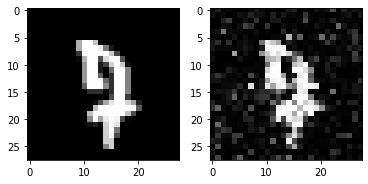

25  :  0.5112596217820842 25
50  :  0.5802275731820214 25
75  :  0.5526275763627009 25
100  :  0.5488447352398098 25
125  :  0.5755965464167349 25
150  :  0.5684325148233794 25
175  :  0.5733347528387815 25
200  :  0.5733347528387815 25
225  :  0.5885147828271169 25
250  :  0.5813311217541087 25
275  :  0.5781834410448136 25
300  :  0.586594878437243 25
325  :  0.5818538646610897 25
350  :  0.5943191859830722 25
375  :  0.5966944938272366 25
400  :  0.5992152694823497 25
425  :  0.6111867779560604 25
450  :  0.6111867779560604 25
475  :  0.6145122810741938 25
500  :  0.6146256903661698 25
525  :  0.6182838044851346 25
550  :  0.6193430873316139 25
575  :  0.6202584643840985 25
600  :  0.6239634739885178 25
625  :  0.6238982174529331 25
650  :  0.6258088169922867 25
675  :  0.6273957548196056 25
700  :  0.6273083838688862 25
725  :  0.6273083838688862 25
750  :  0.6284788285447382 25
775  :  0.6284818981347662 25
800  :  0.6313687586445297 25
825  :  0.6330518832658564 25
850  :  0.6320

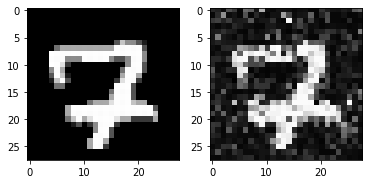

25  :  -0.2296034600421854 25
50  :  0.43714542232644227 25
75  :  0.09038879476598553 25
100  :  0.42106778038934733 25
125  :  0.3474857329000801 25
150  :  0.48938950549527765 25
175  :  0.556761763069624 25
200  :  0.5588843663599122 25
225  :  0.5588843663599122 25
250  :  0.5588843663599122 25
275  :  0.5588843663599122 25
300  :  0.5671592017166134 25
325  :  0.5675601984575644 25
350  :  0.5736423346364247 25
375  :  0.5800150414433793 25
400  :  0.5839732232153535 25
425  :  0.5878757617640843 25
450  :  0.5896514055596935 25
475  :  0.5938074068335737 25
500  :  0.5985385601456354 25
525  :  0.6005231657050544 25
550  :  0.6005231657050544 25
575  :  0.6012930493023018 25
600  :  0.6034430768265875 25
625  :  0.6040236474492063 25
650  :  0.6040236474492063 25
675  :  0.6041028232616604 25
700  :  0.6047304006842724 25
725  :  0.6052397745992074 25
750  :  0.6051248965315452 25
775  :  0.6053167649694976 25
800  :  0.6058584256874525 25
825  :  0.6058969832105366 25
850  :  0

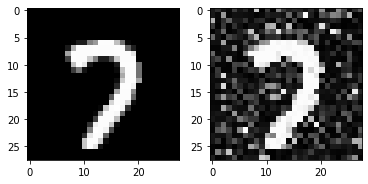

25  :  -0.3293118384137699 25
50  :  0.3718244959021581 25
75  :  -0.3477966482179832 25
100  :  -0.3477966482179832 25
125  :  -0.3477966482179832 25
150  :  -0.3477966482179832 25
175  :  -0.3477966482179832 25
200  :  -0.3477966482179832 25
225  :  -0.3477966482179832 25
250  :  -0.3477966482179832 25
275  :  -0.3477966482179832 25
300  :  -0.3477966482179832 25
325  :  -0.3477966482179832 25
350  :  -0.3477966482179832 25
375  :  -0.3477966482179832 25
400  :  -0.3477966482179832 25
425  :  -0.3477966482179832 25
450  :  -0.3477966482179832 25
475  :  -0.3477966482179832 25
500  :  -0.3477966482179832 25
525  :  -0.3477966482179832 25
550  :  -0.3477966482179832 25
575  :  -0.3477966482179832 25
600  :  -0.3477966482179832 25
625  :  -0.3477966482179832 25
650  :  -0.3477966482179832 25
675  :  -0.3477966482179832 25
700  :  -0.3477966482179832 25
725  :  -0.3477966482179832 25
750  :  -0.3477966482179832 25
775  :  -0.3477966482179832 25
800  :  -0.3477966482179832 25
825  :  -0.3

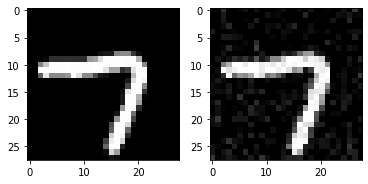

25  :  -0.1961097351361793 25
50  :  0.3379845603636084 25
75  :  -0.1685850840620934 25
100  :  -0.12546132110174074 25
125  :  -0.22454846199232906 25
150  :  -0.3051109130976042 25
175  :  0.21521946580297346 25
200  :  0.324313537914739 25
225  :  0.4813251008334463 25
250  :  0.5445358005670491 25
275  :  0.5602239027656898 25
300  :  0.5602239027656898 25
325  :  0.5602239027656898 25
350  :  0.5784302065929029 25
375  :  0.5784302065929029 25
400  :  0.6094721193431281 25
425  :  0.6097412458990241 25
450  :  0.6097412458990241 25
475  :  0.6155292987330722 25
500  :  0.6174994490162877 25
525  :  0.6174994490162877 25
550  :  0.6175556210544428 25
575  :  0.6206428000688918 25
600  :  0.6206076093751319 25
625  :  0.6213962587643399 25
650  :  0.6246277497763704 25
675  :  0.6249837500392208 25
700  :  0.627990236009862 25
725  :  0.6280070428880158 25
750  :  0.6288385496784036 25
775  :  0.6297709795859497 25
800  :  0.6297951189827353 25
825  :  0.6297951189827353 25
850  : 

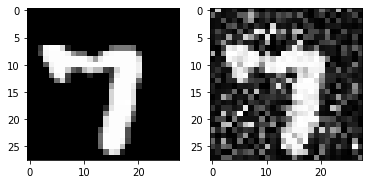

25  :  0.4034954157994689 25
50  :  0.4034954157994689 25
75  :  0.45466959403391893 25
100  :  0.4469624857685769 25
125  :  0.4760865344542875 25
150  :  0.4975440534428408 25
175  :  0.48941975368865026 25
200  :  0.5086905669333422 25
225  :  0.5444938814517502 25
250  :  0.534147546936544 25
275  :  0.5180682582693061 25
300  :  0.5149275997488579 25
325  :  0.5263696251062592 25
350  :  0.549543237213743 25
375  :  0.5437753784316339 25
400  :  0.5520337195124632 25
425  :  0.5461675363608447 25
450  :  0.5491904387255035 25
475  :  0.5461675363608447 25
500  :  0.5509927949281341 25
525  :  0.5551638222944288 25
550  :  0.5527353292050124 25
575  :  0.5563806709326982 25
600  :  0.5630848027185466 25
625  :  0.5625758196155061 25
650  :  0.5681793308223652 25
675  :  0.5627600949068143 25
700  :  0.5629092402852823 25
725  :  0.5640298587165335 25
750  :  0.5676463472040592 25
775  :  0.5677424683806932 25
800  :  0.5684727043864304 25
825  :  0.567742438578353 25
850  :  0.5683

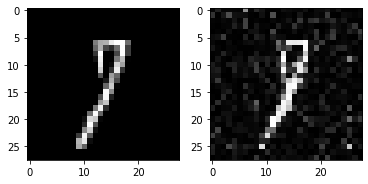

25  :  0.40242876057188093 25
50  :  0.5181876445891644 25
75  :  0.45386958331539784 25
100  :  0.4579084119850911 25
125  :  0.5172811474821418 25
150  :  0.5166524537744434 25
175  :  0.5413743976599126 25
200  :  0.5549538118817674 25
225  :  0.5693710500319007 25
250  :  0.57815416473942 25
275  :  0.5748978219170195 25
300  :  0.5836321944748839 25
325  :  0.5903255342920266 25
350  :  0.5903147966902021 25
375  :  0.5908976069533298 25
400  :  0.5937261498803003 25
425  :  0.5990433922088239 25
450  :  0.6016278575843722 25
475  :  0.6021922858166097 25
500  :  0.6036660515442317 25
525  :  0.6040662994716588 25
550  :  0.604148140107971 25
575  :  0.604889037321368 25
600  :  0.6053854682846568 25
625  :  0.6079113021512244 25
650  :  0.6076506937504944 25
675  :  0.6088869693890446 25
700  :  0.609170190012408 25
725  :  0.609170190012408 25
750  :  0.6095795814041418 25
775  :  0.6097311389701863 25
800  :  0.610141493057275 25
825  :  0.6103413707791123 25
850  :  0.61073672

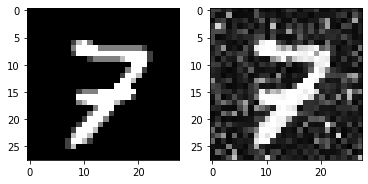

25  :  0.004030375054335733 25
50  :  0.5162431211920087 25
75  :  0.35170734151713867 25
100  :  0.5090048276838361 25
125  :  0.5144547062708712 25
150  :  0.5339316302325838 25
175  :  0.5636747051048406 25
200  :  0.5733958697295853 25
225  :  0.5858674878028133 25
250  :  0.5929394837269537 25
275  :  0.5938121261096396 25
300  :  0.5953347707654127 25
325  :  0.596476344460284 25
350  :  0.596476344460284 25
375  :  0.5974661853020359 25
400  :  0.5995662325166798 25
425  :  0.6031248794157987 25
450  :  0.6046732925244589 25
475  :  0.6056069047883431 25
500  :  0.6065346691556827 25
525  :  0.6071424697865093 25
550  :  0.6124303188435173 25
575  :  0.6128328808393921 25
600  :  0.6128328808393921 25
625  :  0.6128328808393921 25
650  :  0.6132333305125143 25
675  :  0.6143470803326004 25
700  :  0.614506566475171 25
725  :  0.6150256471237534 25
750  :  0.6154067093537376 25
775  :  0.6182617993177852 25
800  :  0.6180293588001479 25
825  :  0.618858409860159 25
850  :  0.6196

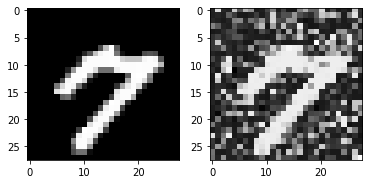

25  :  -0.3408366215354155 25
50  :  -0.3360686531495274 25
75  :  -0.3360686531495274 25
100  :  -0.3360686531495274 25
125  :  -0.3360686531495274 25
150  :  -0.3360686531495274 25
175  :  -0.3360686531495274 25
200  :  -0.3360686531495274 25
225  :  -0.3360686531495274 25
250  :  -0.3360686531495274 25
275  :  -0.3360686531495274 25
300  :  -0.3360686531495274 25
325  :  -0.3360686531495274 25
350  :  -0.3360686531495274 25
375  :  -0.3360686531495274 25
400  :  -0.3360686531495274 25
425  :  -0.3360686531495274 25
450  :  -0.3360686531495274 25
475  :  -0.3360686531495274 25
500  :  -0.3360686531495274 25
525  :  -0.3360686531495274 25
550  :  -0.3360686531495274 25
575  :  -0.3360686531495274 25
600  :  -0.3360686531495274 25
625  :  -0.3360686531495274 25
650  :  -0.3360686531495274 25
675  :  -0.3360686531495274 25
700  :  -0.3360686531495274 25
725  :  -0.3360686531495274 25
750  :  -0.3360686531495274 25
775  :  -0.3360686531495274 25
800  :  -0.3360686531495274 25
Time:  62.2

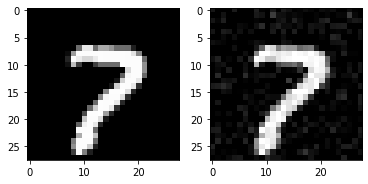

25  :  -0.33679491074068035 25
50  :  -0.23145685847346942 25
75  :  -0.3324262329639142 25
100  :  -0.0967195831616896 25
125  :  0.4293792399223808 25
150  :  0.4449255881254621 25
175  :  0.5134416601445604 25
200  :  0.5412178196729223 25
225  :  0.5440230909709888 25
250  :  0.5570059236941706 25
275  :  0.5610104837287743 25
300  :  0.5661302432878601 25
325  :  0.5714642810726943 25
350  :  0.579053337370988 25
375  :  0.5809826764879007 25
400  :  0.5879695313226136 25
425  :  0.5879695313226136 25
450  :  0.5882835886340093 25
475  :  0.5918973220926638 25
500  :  0.5933502478766729 25
525  :  0.5933502478766729 25
550  :  0.5933502478766729 25
575  :  0.5937152586272877 25
600  :  0.5939069885486495 25
625  :  0.594181304082319 25
650  :  0.5963804051471165 25
675  :  0.5962437110251514 25
700  :  0.5962437110251514 25
725  :  0.5962858562964017 25
750  :  0.597418752487225 25
775  :  0.5974905944498745 25
800  :  0.5979388076374291 25
825  :  0.5984503465254791 25
850  :  0.

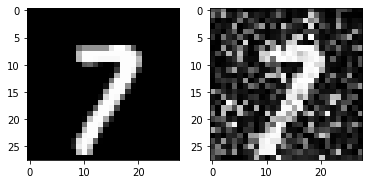

25  :  -0.15026438672903608 25
50  :  0.16749017875883823 25
75  :  0.09423161747220885 25
100  :  0.27227085124251704 25
125  :  0.5419865226232166 25
150  :  0.5722652818536242 25
175  :  0.5783105067850156 25
200  :  0.5826875198709697 25
225  :  0.5854466016762627 25
250  :  0.5859900557645012 25
275  :  0.5867222152299674 25
300  :  0.5883307992464504 25
325  :  0.588434573939944 25
350  :  0.5894885444139415 25
375  :  0.5898419660632772 25
400  :  0.5900908824332624 25
425  :  0.591407711551836 25
450  :  0.592453575235024 25
475  :  0.5942478704304583 25
500  :  0.5944019976331038 25
525  :  0.5946495960916924 25
550  :  0.5958444154564972 25
575  :  0.5958522027501463 25
600  :  0.5958522027501463 25
625  :  0.5960629218633164 25
650  :  0.5962800830843902 25
675  :  0.5971780308141226 25
700  :  0.5971871942409605 25
725  :  0.597529946059166 25
750  :  0.5977882191804145 25
775  :  0.5980023134664999 25
800  :  0.598172503594931 25
825  :  0.5988780912774765 25
850  :  0.598

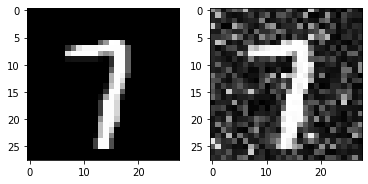

25  :  -0.3664140101267027 25
50  :  -0.3664140101267027 25
75  :  -0.3664140101267027 25
100  :  -0.3664140101267027 25
125  :  -0.3664140101267027 25
150  :  -0.3664140101267027 25
175  :  -0.3664140101267027 25
200  :  -0.3664140101267027 25
225  :  -0.3664140101267027 25
250  :  -0.3664140101267027 25
275  :  -0.3664140101267027 25
300  :  -0.3664140101267027 25
325  :  -0.3664140101267027 25
350  :  -0.3664140101267027 25
375  :  -0.3664140101267027 25
400  :  -0.3664140101267027 25
425  :  -0.3664140101267027 25
450  :  -0.3664140101267027 25
475  :  -0.3664140101267027 25
500  :  -0.3664140101267027 25
525  :  -0.3664140101267027 25
550  :  -0.3664140101267027 25
575  :  -0.3664140101267027 25
600  :  -0.3664140101267027 25
625  :  -0.3664140101267027 25
650  :  -0.3664140101267027 25
675  :  -0.3664140101267027 25
700  :  -0.3664140101267027 25
725  :  -0.3664140101267027 25
750  :  -0.3664140101267027 25
775  :  -0.3664140101267027 25
800  :  -0.3664140101267027 25
Time:  63.5

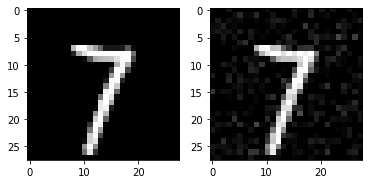

25  :  -0.1273997461368515 25
50  :  0.0849574315536998 25
75  :  0.23138215161529496 25
100  :  0.3699071756551231 25
125  :  0.528261735952968 25
150  :  0.5511949868533944 25
175  :  0.5511949868533944 25
200  :  0.5536281229192901 25
225  :  0.5538890408793847 25
250  :  0.556291270705549 25
275  :  0.5643745878230133 25
300  :  0.5679863078441036 25
325  :  0.5696030918258486 25
350  :  0.5708618128289986 25
375  :  0.5724046924230355 25
400  :  0.5749499910961464 25
425  :  0.5750368339571273 25
450  :  0.5750368339571273 25
475  :  0.5758215612402988 25
500  :  0.5758215612402988 25
525  :  0.5758215612402988 25
550  :  0.5764974979085321 25
575  :  0.5776744540103628 25
600  :  0.5786801349258839 25
625  :  0.578723250449386 25
650  :  0.5792026960674473 25
675  :  0.5793599180742937 25
700  :  0.5793607317848567 25
725  :  0.5799717608341735 25
750  :  0.5808342528778323 25
775  :  0.58109307825243 25
800  :  0.5812078325740224 25
825  :  0.5815694800652972 25
850  :  0.582067

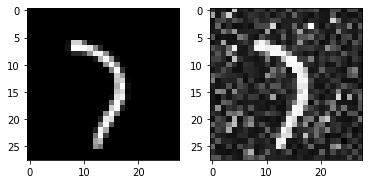

25  :  -0.10114053701902767 25
50  :  0.5777501776689294 25
75  :  0.5208967388694579 25
100  :  0.5616305358756225 25
125  :  0.5373911282937356 25
150  :  0.4568737720235277 25
175  :  0.5600631316242416 25
200  :  0.37570023198968394 25
225  :  0.5276385503759681 25
250  :  0.5509056247611195 25
275  :  0.579740279060748 25
300  :  0.5851238762623249 25
325  :  0.5856150493080418 25
350  :  0.5862521328143224 25
375  :  0.5896256061472598 25
400  :  0.5949063427827451 25
425  :  0.5946320519522414 25
450  :  0.5946320519522414 25
475  :  0.5949591240687875 25
500  :  0.5956786229091691 25
525  :  0.5970560861143749 25
550  :  0.5972162066885827 25
575  :  0.5988166318515031 25
600  :  0.6011869960613563 25
625  :  0.6011507567745732 25
650  :  0.601179211655052 25
675  :  0.6023792661965086 25
700  :  0.6032710865982067 25
725  :  0.6032710865982067 25
750  :  0.6035699177668652 25
775  :  0.6035472972784349 25
800  :  0.6053149836400284 25
825  :  0.6064282704973606 25
850  :  0.60

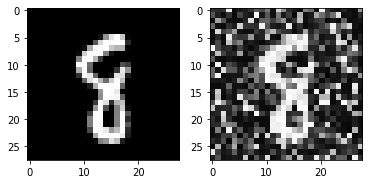

25  :  0.2782964884162834 25
50  :  0.5809094391224155 25
75  :  0.2873791674946782 25
100  :  0.4282910714055423 25
125  :  0.5274575018513914 25
150  :  0.49916413753020134 25
175  :  0.5358869609950714 25
200  :  0.49813803804702195 25
225  :  0.5512788392408383 25
250  :  0.555126222627405 25
275  :  0.5580441937884766 25
300  :  0.5676789268569551 25
325  :  0.567616929463542 25
350  :  0.588084408280739 25
375  :  0.5754643548888284 25
400  :  0.5837958681305196 25
425  :  0.5846299419763203 25
450  :  0.5896132616740659 25
475  :  0.5805503163442429 25
500  :  0.5844611186437113 25
525  :  0.5865288622592493 25
550  :  0.590026272947075 25
575  :  0.5906252083966621 25
600  :  0.5901148767664154 25
625  :  0.5907037094111824 25
650  :  0.5920549421231058 25
675  :  0.5933676301889493 25
700  :  0.5954617947782794 25
725  :  0.5955329384061484 25
750  :  0.5983866296366489 25
775  :  0.5997892066316535 25
800  :  0.5999230400651173 25
825  :  0.6012367608940044 25
850  :  0.60045

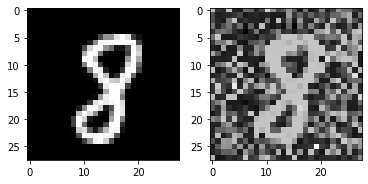

25  :  0.5037720530205848 25
50  :  0.5929099284231362 25
75  :  0.5665591858860201 25
100  :  0.5797768151939414 25
125  :  0.5766919036387326 25
150  :  0.5712700360569323 25
175  :  0.5876382872466048 25
200  :  0.5857039342545706 25
225  :  0.5805396203722012 25
250  :  0.5859386136131975 25
275  :  0.5900628731073406 25
300  :  0.5880606666461289 25
325  :  0.5928981007139442 25
350  :  0.5997245835430092 25
375  :  0.6030367398288626 25
400  :  0.6050287966523495 25
425  :  0.6051570877215727 25
450  :  0.6073856607129378 25
475  :  0.6076080454293789 25
500  :  0.6107576609031617 25
525  :  0.6138720246594207 25
550  :  0.614043099450062 25
575  :  0.614043099450062 25
600  :  0.6159185791351216 25
625  :  0.6163763411958963 25
650  :  0.616972472300532 25
675  :  0.6180647888823342 25
700  :  0.6181349867263954 25
725  :  0.6183199947623119 25
750  :  0.6197792829526289 25
775  :  0.6203783680077792 25
800  :  0.6204725054009663 25
825  :  0.6214589587939308 25
850  :  0.622019

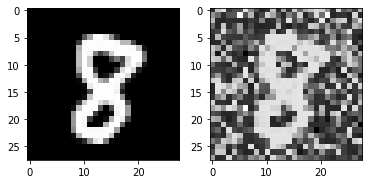

25  :  0.49631609197617355 25
50  :  0.6056641958975056 25
75  :  0.6074801540597502 25
100  :  0.6089721475420893 25
125  :  0.6020910522650731 25
150  :  0.5989129565263974 25
175  :  0.6060577560572542 25
200  :  0.6044422443021444 25
225  :  0.6138655214802069 25
250  :  0.6190705260965211 25
275  :  0.6245993305586024 25
300  :  0.6269495743311151 25
325  :  0.6318198247487845 25
350  :  0.6289444743999828 25
375  :  0.6291366467959472 25
400  :  0.6283404752197433 25
425  :  0.6284666856089909 25
450  :  0.6284443738743513 25
475  :  0.6283404752197433 25
500  :  0.6284526310011804 25
525  :  0.6286494758914504 25
550  :  0.6293198158799943 25
575  :  0.6295120236968625 25
600  :  0.6294796269288031 25
625  :  0.630672383810003 25
650  :  0.630488766922174 25
675  :  0.630942227656301 25
700  :  0.6317864410402332 25
725  :  0.6329503196330888 25
750  :  0.6338042965453887 25
775  :  0.6341998304707022 25
800  :  0.6347028345916123 25
825  :  0.6355354393470046 25
Time:  62.43284

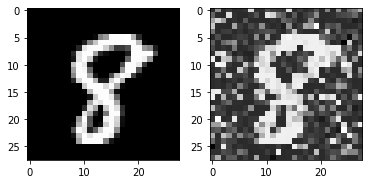

25  :  0.5067393815886128 25
50  :  0.6090426355491384 25
75  :  0.5974790205196218 25
100  :  0.5923342645307854 25
125  :  0.6040584721980615 25
150  :  0.5939157005144603 25
175  :  0.6065112980780426 25
200  :  0.6111076070877994 25
225  :  0.6090536816896245 25
250  :  0.6116612188056967 25
275  :  0.6161082352071152 25
300  :  0.6175459062414077 25
325  :  0.6177325416163808 25
350  :  0.6229974444032133 25
375  :  0.620889482015555 25
400  :  0.6228442621096311 25
425  :  0.6228442621096311 25
450  :  0.6237997707948277 25
475  :  0.6267255915634419 25
500  :  0.6253399291600985 25
525  :  0.6251606435730328 25
550  :  0.6276955243269506 25
575  :  0.6285671764144255 25
600  :  0.6287477178289717 25
625  :  0.6288062192418471 25
650  :  0.630314878394068 25
675  :  0.6303867926993536 25
700  :  0.6321178057651856 25
725  :  0.6322224892907998 25
750  :  0.6322437169293131 25
775  :  0.6329291155324718 25
800  :  0.6331530657075815 25
825  :  0.6332337935381266 25
850  :  0.63426

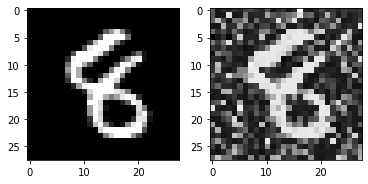

25  :  0.34122923035661434 25
50  :  0.6055568446951581 25
75  :  0.5210150340081102 25
100  :  0.5944035013431597 25
125  :  0.5782085300988119 25
150  :  0.5655119582227666 25
175  :  0.5753212123678293 25
200  :  0.5866462739987184 25
225  :  0.5765775654967498 25
250  :  0.5896726155548208 25
275  :  0.5928937637410312 25
300  :  0.6006836793265934 25
325  :  0.5902336007988227 25
350  :  0.595692147547281 25
375  :  0.5929875551781564 25
400  :  0.594962301225468 25
425  :  0.5959714219052864 25
450  :  0.5935283071992014 25
475  :  0.6003416452360144 25
500  :  0.5959784328097248 25
525  :  0.5992560747420443 25
550  :  0.6019219467631225 25
575  :  0.6024416684708427 25
600  :  0.6035263439407783 25
625  :  0.6036462353135061 25
650  :  0.6036806099041572 25
675  :  0.6052359411398901 25
700  :  0.6086470562012 25
725  :  0.6122916725898818 25
750  :  0.612846993034214 25
775  :  0.6122443491538303 25
800  :  0.6122444274962618 25
825  :  0.6130205377025995 25
850  :  0.61330798

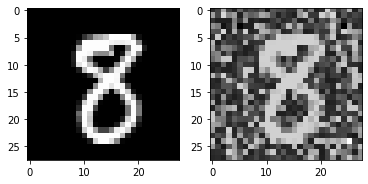

25  :  0.5322331368264774 25
50  :  0.5930982448398948 25
75  :  0.568704563383465 25
100  :  0.5847391288266289 25
125  :  0.5685570803224653 25
150  :  0.5670603895985877 25
175  :  0.5834832134991748 25
200  :  0.5778473890421093 25
225  :  0.5945424834443379 25
250  :  0.5878238988290675 25
275  :  0.5887409481273831 25
300  :  0.5871188981604338 25
325  :  0.5915464906792531 25
350  :  0.5944284266690014 25
375  :  0.5932563436098586 25
400  :  0.595264783506969 25
425  :  0.5972995304688085 25
450  :  0.598718059727092 25
475  :  0.6001647064442852 25
500  :  0.6024890404664138 25
525  :  0.6035498206859257 25
550  :  0.6035498206859257 25
575  :  0.6042441462393388 25
600  :  0.6061353941769555 25
625  :  0.6061051098418972 25
650  :  0.6067892857408484 25
675  :  0.6068711137849412 25
700  :  0.6079460258891587 25
725  :  0.6081350001353956 25
750  :  0.6084814174234886 25
775  :  0.6085891243630582 25
800  :  0.6084814174234886 25
825  :  0.6095632044774713 25
850  :  0.609555

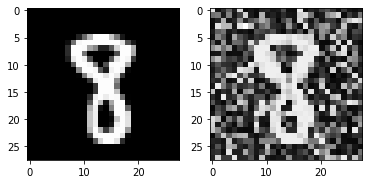

25  :  0.3260109681226796 25
50  :  0.5413038947123787 25
75  :  0.41233616487693897 25
100  :  0.4070770720154234 25
125  :  0.49316845073997223 25
150  :  0.5483644078470493 25
175  :  0.5543265541587046 25
200  :  0.5638126152168009 25
225  :  0.5607937588538556 25
250  :  0.5710654611932644 25
275  :  0.5762718910328568 25
300  :  0.5816597354585776 25
325  :  0.5798651702830299 25
350  :  0.5865068140911512 25
375  :  0.5880395119537182 25
400  :  0.5866506692039253 25
425  :  0.5932291324844718 25
450  :  0.5925606918267425 25
475  :  0.5945627914314291 25
500  :  0.5933511747236515 25
525  :  0.5966208134917368 25
550  :  0.5960015260472651 25
575  :  0.5963336640500092 25
600  :  0.5963336640500092 25
625  :  0.599911062250958 25
650  :  0.5996751849865085 25
675  :  0.5996751849865085 25
700  :  0.5998233305461778 25
725  :  0.5997643995099533 25
750  :  0.6000609597245443 25
775  :  0.6005477787666724 25
800  :  0.6009053423062473 25
825  :  0.6019244531489413 25
850  :  0.60

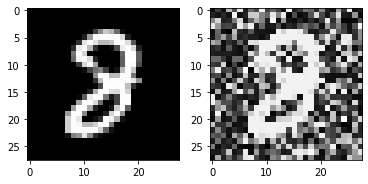

25  :  0.6634670026787779 25
50  :  0.6727510661998791 25
75  :  0.6536998208753229 25
100  :  0.6385239828563413 25
125  :  0.6373932056043601 25
150  :  0.6280888793988182 25
175  :  0.629145032281638 25
200  :  0.6247507797649663 25
225  :  0.6421809305136937 25
250  :  0.6361356687398261 25
275  :  0.6444566213699454 25
300  :  0.6440093500743019 25
325  :  0.6433784743148163 25
350  :  0.6430118085246191 25
375  :  0.643278835250688 25
400  :  0.646380772407573 25
425  :  0.6477847963161563 25
450  :  0.6495277444182129 25
475  :  0.6495277444182129 25
500  :  0.6501156018056957 25
525  :  0.6506221206263919 25
550  :  0.6506297209687908 25
575  :  0.6523540680409821 25
600  :  0.6523165931629921 25
625  :  0.6524132032943387 25
650  :  0.6525876724288702 25
675  :  0.6535359525196818 25
700  :  0.6547601407734439 25
725  :  0.6555272329122735 25
750  :  0.6555038318394617 25
775  :  0.6556904701190143 25
800  :  0.6564478054592978 25
825  :  0.6564172228136917 25
850  :  0.656886

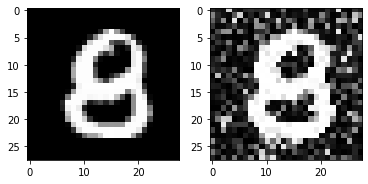

25  :  0.5579495474773444 25
50  :  0.5921918962885182 25
75  :  0.5556773283373861 25
100  :  0.5903374400306167 25
125  :  0.43257059435713574 25
150  :  0.4357560922767761 25
175  :  0.5435593138086672 25
200  :  0.4212121848904605 25
225  :  0.5517035397639312 25
250  :  0.5838760785959856 25
275  :  0.5182293349688123 25
300  :  0.17398465742125097 25
325  :  -0.2997983071096666 25
350  :  0.46063822661831855 25
375  :  0.3695456221483981 25
400  :  -0.2997983071096666 25
425  :  -0.2992515874889564 25
450  :  -0.2992515874889564 25
475  :  -0.2987899600154189 25
500  :  -0.2988300383509473 25
525  :  -0.2988300383509473 25
550  :  -0.2983309917214061 25
575  :  -0.2983309917214061 25
600  :  -0.2983309917214061 25
625  :  -0.2982690440709478 25
650  :  -0.29787556181217245 25
675  :  -0.29778179792479276 25
700  :  -0.2977503597265398 25
725  :  -0.2976588281034977 25
750  :  -0.29744647348208225 25
775  :  -0.2974475235942871 25
800  :  -0.2973096222358812 25
825  :  -0.29718080

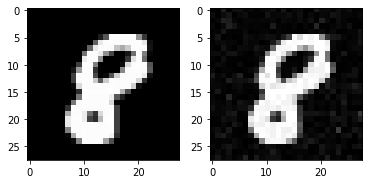

25  :  0.3405218658506388 25
50  :  0.6163792387230728 25
75  :  0.6127273057827424 25
100  :  0.6056507398282582 25
125  :  0.609244826206991 25
150  :  0.6125680103641565 25
175  :  0.6008933429653871 25
200  :  0.6075433454236265 25
225  :  0.603044817949774 25
250  :  0.6078840008456621 25
275  :  0.6140713732913401 25
300  :  0.6181197003545298 25
325  :  0.6172030855537539 25
350  :  0.6158247137509553 25
375  :  0.6162233033490883 25
400  :  0.6166804603487509 25
425  :  0.6178161622893701 25
450  :  0.620900754855516 25
475  :  0.6236101023612978 25
500  :  0.6236101023612978 25
525  :  0.6236101023612978 25
550  :  0.6246055216535156 25
575  :  0.6254327039543709 25
600  :  0.6276377583018264 25
625  :  0.6277833570451201 25
650  :  0.6277833570451201 25
675  :  0.6277833570451201 25
700  :  0.6282580752504583 25
725  :  0.6287753797230123 25
750  :  0.6287459478962854 25
775  :  0.6289187679701869 25
800  :  0.6289167164673765 25
825  :  0.6299123932800408 25
850  :  0.630445

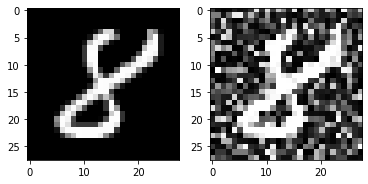

25  :  0.5819235241855459 25
50  :  0.6080698813572303 25
75  :  0.4891392858323895 25
100  :  0.5870816375799042 25
125  :  0.5818766573039924 25
150  :  0.5864854930483933 25
175  :  0.5920968626488873 25
200  :  0.5902800847818556 25
225  :  0.590086016703817 25
250  :  0.5926206367898874 25
275  :  0.5944175441493795 25
300  :  0.5989163332366345 25
325  :  0.5994563590417553 25
350  :  0.6023044384757608 25
375  :  0.6058100715451091 25
400  :  0.6083223412676184 25
425  :  0.6088256234648521 25
450  :  0.6107630740653216 25
475  :  0.6108559415905875 25
500  :  0.6116336397283288 25
525  :  0.6125973930250249 25
550  :  0.6126524403898281 25
575  :  0.6131584606860025 25
600  :  0.6143561731006214 25
625  :  0.6143260586858981 25
650  :  0.6145637858761117 25
675  :  0.6145306667291512 25
700  :  0.6148683285996392 25
725  :  0.6151252765301379 25
750  :  0.6153827932745874 25
775  :  0.6157459912854709 25
800  :  0.6158177376731033 25
825  :  0.6159780963715062 25
850  :  0.6160

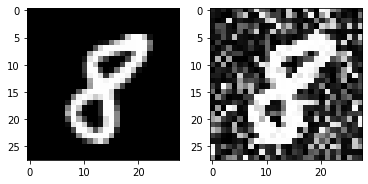

25  :  -0.11563229602251804 25
50  :  0.1612965075187533 25
75  :  0.01873385103650904 25
100  :  0.013988482481488734 25
125  :  0.04903194637522745 25
150  :  0.1853025914561696 25
175  :  0.4768861605969098 25
200  :  0.5314735529628649 25
225  :  0.5158840124082087 25
250  :  0.499178325869703 25
275  :  0.5298442192268159 25
300  :  0.5275957317418427 25
325  :  0.5191299654373955 25
350  :  0.5487508827940142 25
375  :  0.5475582568344245 25
400  :  0.5554834903986248 25
425  :  0.5556177002321454 25
450  :  0.563803625721204 25
475  :  0.5628719146302847 25
500  :  0.5706107415016671 25
525  :  0.572071025378545 25
550  :  0.5719290444140811 25
575  :  0.5727321618367477 25
600  :  0.5728667175880444 25
625  :  0.5764350287495714 25
650  :  0.5789206306541854 25
675  :  0.5795783990347685 25
700  :  0.5816089804785025 25
725  :  0.5835135960415533 25
750  :  0.5846379762131917 25
775  :  0.5849163342414281 25
800  :  0.5887088482162312 25
825  :  0.5884665563828049 25
850  :  0.

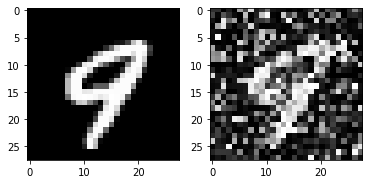

25  :  -0.30875343544889605 25
50  :  -0.30875343544889605 25
75  :  -0.30875343544889605 25
100  :  -0.30875343544889605 25
125  :  -0.30875343544889605 25
150  :  -0.30875343544889605 25
175  :  -0.30875343544889605 25
200  :  -0.30875343544889605 25
225  :  -0.30875343544889605 25
250  :  -0.30875343544889605 25
275  :  -0.30875343544889605 25
300  :  -0.30875343544889605 25
325  :  -0.30875343544889605 25
350  :  -0.30875343544889605 25
375  :  -0.30875343544889605 25
400  :  -0.30875343544889605 25
425  :  -0.30875343544889605 25
450  :  -0.30875343544889605 25
475  :  -0.30875343544889605 25
500  :  -0.30875343544889605 25
525  :  -0.30875343544889605 25
550  :  -0.3084058677892567 25
575  :  -0.30842525834272655 25
600  :  -0.30836537067330294 25
625  :  -0.3083336974100507 25
650  :  -0.30789572946541943 25
675  :  -0.30790168065193707 25
700  :  -0.30790168065193707 25
725  :  -0.30790168065193707 25
750  :  -0.30790168065193707 25
775  :  -0.30766731806906267 25
800  :  -0.30

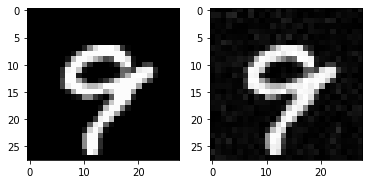

25  :  0.2806005560870747 25
50  :  0.5655687314294271 25
75  :  0.5245092513865222 25
100  :  0.5548438791493736 25
125  :  0.573955831210206 25
150  :  0.5847334323081054 25
175  :  0.5860508440307213 25
200  :  0.5864381305471835 25
225  :  0.5912442548785262 25
250  :  0.5912442548785262 25
275  :  0.5932931868585279 25
300  :  0.5946361416196988 25
325  :  0.5998187898937078 25
350  :  0.5998748562727535 25
375  :  0.6006231141482451 25
400  :  0.6006231141482451 25
425  :  0.6006231141482451 25
450  :  0.6007841894205629 25
475  :  0.6027123039490002 25
500  :  0.6030130296866993 25
525  :  0.6043900105326618 25
550  :  0.6043900105326618 25
575  :  0.6047098291088375 25
600  :  0.6050022950632217 25
625  :  0.6050022950632217 25
650  :  0.6057864444716549 25
675  :  0.6068919157201569 25
700  :  0.6068918263131897 25
725  :  0.6068918263131897 25
750  :  0.6069415238688884 25
775  :  0.6074719731993325 25
800  :  0.6080343459537945 25
825  :  0.6082560077303003 25
850  :  0.6087

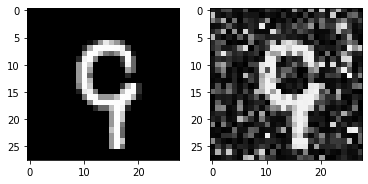

25  :  -0.1434545357179187 25
50  :  -0.10615839333554253 25
75  :  -0.017418388401202856 25
100  :  0.002616659013974426 25
125  :  0.19782634251902523 25
150  :  0.2711851373135212 25
175  :  0.5323257146707339 25
200  :  0.5701053742843659 25
225  :  0.5869072238391237 25
250  :  0.6019041316392912 25
275  :  0.6123369217162855 25
300  :  0.612605763503243 25
325  :  0.612605763503243 25
350  :  0.612605763503243 25
375  :  0.6143366230495984 25
400  :  0.6214667752351588 25
425  :  0.6216001255693452 25
450  :  0.6233720583626909 25
475  :  0.623951980963859 25
500  :  0.6239688737054813 25
525  :  0.6245804216347639 25
550  :  0.6270719024973989 25
575  :  0.6293530523295242 25
600  :  0.6313632074024741 25
625  :  0.6323323818765173 25
650  :  0.6332982128367923 25
675  :  0.6344961625609842 25
700  :  0.6344848973402154 25
725  :  0.6354853455985859 25
750  :  0.6355500902539916 25
775  :  0.6356455020670375 25
800  :  0.6361970561348257 25
825  :  0.6364744860632353 25
850  :  

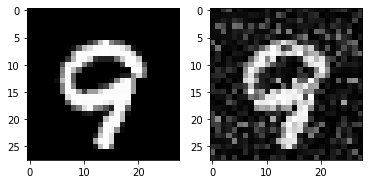

25  :  -0.23531711618934106 25
50  :  -0.22499114494173728 25
75  :  -0.2104465179545256 25
100  :  -0.15808116427811447 25
125  :  -0.05351126674534293 25
150  :  0.13231100805701426 25
175  :  0.4137400678847777 25
200  :  0.49066001450702124 25
225  :  0.5396474134651077 25
250  :  0.563577903871875 25
275  :  0.576368674209321 25
300  :  0.5689777361257401 25
325  :  0.5704933098558032 25
350  :  0.5753831751102441 25
375  :  0.5782619545248058 25
400  :  0.5833200540692882 25
425  :  0.582194176686432 25
450  :  0.5824234731152764 25
475  :  0.5826503203828333 25
500  :  0.585141256029155 25
525  :  0.5850107098520558 25
550  :  0.5850528495958456 25
575  :  0.5853524170001312 25
600  :  0.5882800413511917 25
625  :  0.5907222316382319 25
650  :  0.5905320336082459 25
675  :  0.5911928191736323 25
700  :  0.5918723862520292 25
725  :  0.5920245493969006 25
750  :  0.5938835447759605 25
775  :  0.5941281007261254 25
800  :  0.5953395449062157 25
825  :  0.5959711884861967 25
850  :

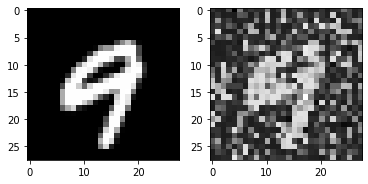

25  :  -0.2884042190952042 25
50  :  -0.28317182988714173 25
75  :  -0.27959224422187146 25
100  :  -0.27524929842349455 25
125  :  -0.2587159131274898 25
150  :  -0.19554220837077757 25
175  :  -0.1387514706607667 25
200  :  -0.04891815717853476 25
225  :  0.14659364649100157 25
250  :  0.4141858473911538 25
275  :  0.5297069948174095 25
300  :  0.48562226591447827 25
325  :  0.5361578854469037 25
350  :  0.5644503976475953 25
375  :  0.5713437752645149 25
400  :  0.5713437752645149 25
425  :  0.5776861686876813 25
450  :  0.5833673223939012 25
475  :  0.5879397401628851 25
500  :  0.5890112464350451 25
525  :  0.5913620466478035 25
550  :  0.5919397203840066 25
575  :  0.5968809392594188 25
600  :  0.5973408528166683 25
625  :  0.5997429482858861 25
650  :  0.6002210725975273 25
675  :  0.6010774612514884 25
700  :  0.6010853735257958 25
725  :  0.6030415798355787 25
750  :  0.6043184375055328 25
775  :  0.605488748215347 25
800  :  0.6060219293528176 25
825  :  0.6063558141252468 25

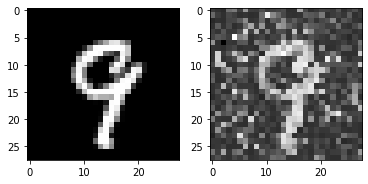

25  :  -0.18216307300603146 25
50  :  0.10149661113099398 25
75  :  0.18205511310302677 25
100  :  0.3527215007664075 25
125  :  0.3524283604087882 25
150  :  0.4885461604627766 25
175  :  0.49391206974878726 25
200  :  0.528453267491799 25
225  :  0.5314507692535818 25
250  :  0.5469261944927298 25
275  :  0.5469261944927298 25
300  :  0.5670412725084287 25
325  :  0.5757179647726431 25
350  :  0.5757179647726431 25
375  :  0.5757179647726431 25
400  :  0.5841714990745357 25
425  :  0.5841714990745357 25
450  :  0.5850003126901351 25
475  :  0.5884144520682557 25
500  :  0.5914631205814845 25
525  :  0.5935838029780084 25
550  :  0.5935644564219594 25
575  :  0.5946125357079304 25
600  :  0.5949562652071911 25
625  :  0.5949830866391222 25
650  :  0.5949562652071911 25
675  :  0.5952364341332408 25
700  :  0.5952761512331111 25
725  :  0.5952870705167765 25
750  :  0.5952870705167765 25
775  :  0.5956067693986371 25
800  :  0.5956067693986371 25
825  :  0.5960815140781074 25
850  :  0

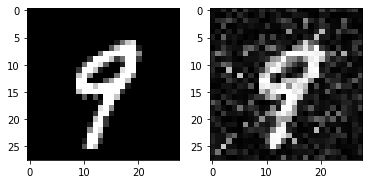

25  :  0.25732970052726134 25
50  :  0.5519179478183502 25
75  :  0.4729966410655665 25
100  :  0.46713624696822087 25
125  :  0.4276647060363683 25
150  :  0.5260788475010371 25
175  :  0.5274263408465123 25
200  :  0.5573464885333743 25
225  :  0.5808565704939241 25
250  :  0.5833096863397969 25
275  :  0.5849960187528064 25
300  :  0.5822752688317686 25
325  :  0.5855355347163919 25
350  :  0.5874400700526237 25
375  :  0.5877932594991742 25
400  :  0.5883491139039106 25
425  :  0.5901120948250647 25
450  :  0.5916633181516349 25
475  :  0.5932180514898575 25
500  :  0.5951582593248985 25
525  :  0.5946331221038982 25
550  :  0.5961740286883729 25
575  :  0.5989494630718418 25
600  :  0.5992352206919604 25
625  :  0.5995775429337494 25
650  :  0.6003591992325898 25
675  :  0.6004839376724824 25
700  :  0.6007650804034239 25
725  :  0.6017061600659491 25
750  :  0.6020317305195059 25
775  :  0.6020452956305805 25
800  :  0.6020495056989048 25
825  :  0.6024335720405033 25
850  :  0.6

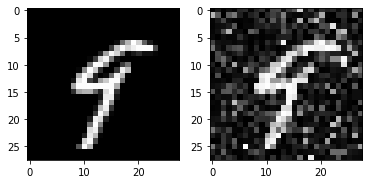

25  :  -0.30078533309588196 25
50  :  0.5515224224226009 25
75  :  -0.30851846086464013 25
100  :  -0.30851846086464013 25
125  :  -0.3080313375013554 25
150  :  -0.3080313375013554 25
175  :  -0.3080313375013554 25
200  :  -0.3080313375013554 25
225  :  -0.3080313375013554 25
250  :  -0.3080313375013554 25
275  :  -0.3080313375013554 25
300  :  -0.3080313375013554 25
325  :  -0.3080313375013554 25
350  :  -0.3080313375013554 25
375  :  -0.3080313375013554 25
400  :  -0.3080313375013554 25
425  :  -0.3080313375013554 25
450  :  -0.3080313375013554 25
475  :  -0.3080313375013554 25
500  :  -0.3080313375013554 25
525  :  -0.3080313375013554 25
550  :  -0.3080313375013554 25
575  :  -0.3080313375013554 25
600  :  -0.3080313375013554 25
625  :  -0.3080313375013554 25
650  :  -0.3080313375013554 25
675  :  -0.3080313375013554 25
700  :  -0.3080313375013554 25
725  :  -0.3080313375013554 25
750  :  -0.3080313375013554 25
775  :  -0.3080313375013554 25
800  :  -0.3080313375013554 25
825  :  -

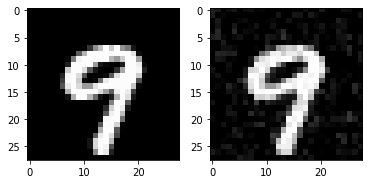

25  :  -0.06228617791499573 25
50  :  0.516657206622375 25
75  :  0.36036244317301985 25
100  :  0.4382429657804973 25
125  :  0.5006742904079372 25
150  :  0.518852689268595 25
175  :  0.5454390180965083 25
200  :  0.5631187350580171 25
225  :  0.5677735475706157 25
250  :  0.5789027957447288 25
275  :  0.578190304252089 25
300  :  0.5824202537195355 25
325  :  0.5833695238952258 25
350  :  0.5840628435063714 25
375  :  0.5933886083902009 25
400  :  0.5933886083902009 25
425  :  0.596061495678544 25
450  :  0.5973549025749432 25
475  :  0.5989294792977241 25
500  :  0.5990510722386658 25
525  :  0.6006701803935515 25
550  :  0.6026336144290574 25
575  :  0.6045436895618307 25
600  :  0.6050647966495764 25
625  :  0.6062647412393533 25
650  :  0.6066055611583016 25
675  :  0.6072660939969963 25
700  :  0.6075399282774829 25
725  :  0.607983989758682 25
750  :  0.6082534763021995 25
775  :  0.6081795488446913 25
800  :  0.6082728345108869 25
825  :  0.6089888384525944 25
850  :  0.61004

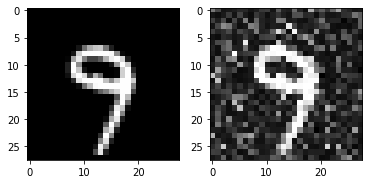

25  :  0.6309229285265845 25
50  :  0.6360547662627891 25
75  :  0.6239900862994803 25
100  :  0.6203303888578187 25
125  :  0.6107725937836286 25
150  :  0.6164005948030439 25
175  :  0.6209558264856636 25
200  :  0.6259641010127353 25
225  :  0.6278219643951619 25
250  :  0.6290690921036713 25
275  :  0.6332101060821449 25
300  :  0.6338618961407976 25
325  :  0.6352194723497425 25
350  :  0.6351129523155462 25
375  :  0.6351129523155462 25
400  :  0.6351129523155462 25
425  :  0.6351129523155462 25
450  :  0.6375320388474263 25
475  :  0.6384759291007033 25
500  :  0.6384759291007033 25
525  :  0.6384759291007033 25
550  :  0.6385629379149167 25
575  :  0.6397681487740154 25
600  :  0.6404139916646966 25
625  :  0.640952157143633 25
650  :  0.6409645783860554 25
675  :  0.6417909456513955 25
700  :  0.6424138400929176 25
725  :  0.6428068015418877 25
750  :  0.6428068015418877 25
775  :  0.6432474368183223 25
800  :  0.643346432020394 25
825  :  0.6434209337639043 25
850  :  0.64347

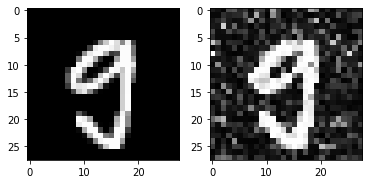

25  :  -0.25604922864333646 25
50  :  -0.22872852231491453 25
75  :  -0.20806516078367437 25
100  :  -0.14860185505675966 25
125  :  -0.11689852845924209 25
150  :  0.027079130326252088 25
175  :  0.3579012461679553 25
200  :  0.3426358074535523 25
225  :  0.5408777051054434 25
250  :  0.5592536626805968 25
275  :  0.5642754735798093 25
300  :  0.5641755276006137 25
325  :  0.5669468807703472 25
350  :  0.5638195940077606 25
375  :  0.5671451565496477 25
400  :  0.5706890435728791 25
425  :  0.572973613459008 25
450  :  0.5757105320879452 25
475  :  0.5774485400433204 25
500  :  0.5796432575064727 25
525  :  0.5794547837206908 25
550  :  0.5817144554326321 25
575  :  0.5816258239606118 25
600  :  0.5845176139229311 25
625  :  0.5846006160980869 25
650  :  0.5849391500063906 25
675  :  0.5844395236537661 25
700  :  0.5892397298438201 25
725  :  0.5910090241986956 25
750  :  0.5906852417991051 25
775  :  0.5923130266276728 25
800  :  0.5929086104198964 25
825  :  0.5930142422286728 25
85

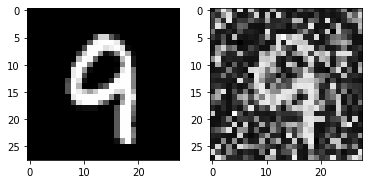

25  :  -0.20269502122376082 25
50  :  -0.1589841546010351 25
75  :  0.06612563610382882 25
100  :  -0.10699748698495412 25
125  :  -0.027708217703049154 25
150  :  0.053060396567761986 25
175  :  0.20744605219740872 25
200  :  0.25387932517984557 25
225  :  0.5075735691014175 25
250  :  0.5488810996761597 25
275  :  0.5397131910127221 25
300  :  0.5495687708597629 25
325  :  0.5521146202840647 25
350  :  0.550749483515469 25
375  :  0.5502162199202192 25
400  :  0.5509301883586881 25
425  :  0.5523685188703695 25
450  :  0.555865762572847 25
475  :  0.5608202127051649 25
500  :  0.5643844906492027 25
525  :  0.5659998317698823 25
550  :  0.5659998317698823 25
575  :  0.5675581255464707 25
600  :  0.5675581255464707 25
625  :  0.5675581255464707 25
650  :  0.567951697809669 25
675  :  0.5682625188659987 25
700  :  0.5689700820075834 25
725  :  0.5704110730811481 25
750  :  0.5714498977321878 25
775  :  0.5725264758791668 25
800  :  0.5743775010423049 25
825  :  0.576760704531135 25
850 

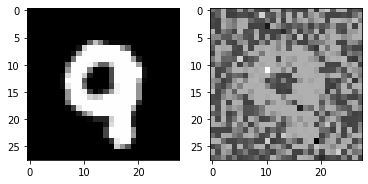

In [21]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28*28) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_rbf_mnist_ssim', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [23]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

135.3601415157318
61.652857065200806
82.82167443396553
13.536115417057854


In [24]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

1793
800
1026.5714285714287
168.489716542283


In [25]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

28.69011771301606
5.312589004050854
13.975560579741957
6.206769720779421
